In [ ]:
##Preliminary imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Layer, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, Callback
import gc

In [ ]:
cnv_ccle=pd.read_csv("/content/drive/MyDrive/DROEG/cnv_ccle.csv", index_col=0)
med_ccle=pd.read_csv("/content/drive/MyDrive/DROEG/drugResponse_ccle.csv", index_col=0)
meth_ccle=pd.read_csv("/content/drive/MyDrive/DROEG/meth_ccle.csv", index_col=0)
mrna_ccle=pd.read_excel("/content/drive/MyDrive/DROEG/prep_mrna_ccle.xlsx", index_col=0)
mut_ccle=pd.read_csv("/content/drive/MyDrive/DROEG/mutation_ccle.csv", index_col=0)
cnv_gdsc=pd.read_csv("/content/drive/MyDrive/DROEG/cnv_fullgdsc.csv", index_col=0)
med_gdsc=pd.read_csv("/content/drive/MyDrive/DROEG/gdsc_fulldrugResponse.csv", index_col=0)
meth_gdsc=pd.read_csv("/content/drive/MyDrive/DROEG/meth_fullgdsc.csv", index_col=0)
mrna_gdsc=pd.read_excel("/content/drive/MyDrive/DROEG/prep_mrna_gdsc.xlsx", index_col=0)
mut_gdsc=pd.read_csv("/content/drive/MyDrive/DROEG/mutation_fullgdsc.csv", index_col=0)
features=pd.read_excel("/content/drive/MyDrive/DROEG/features_ccle.xlsx", index_col=0)

In [ ]:
y_dummy_ccle=pd.read_excel("/content/drive/MyDrive/DROEG/y_dummy_ccle.xlsx",index_col=0)
y_dummy_gdsc=pd.read_excel("/content/drive/MyDrive/DROEG/y_dummy_gdsc.xlsx",index_col=0)

In [ ]:
##Make a copy
all_y_dummy_gdsc=y_dummy_gdsc

In [ ]:
##Select the common cell lines and common drugs to CCLE and GDSC
common_cell_lines=y_dummy_gdsc.index.intersection(y_dummy_ccle.index)
common_drugs=[]
for col in y_dummy_gdsc.columns:
  if col in y_dummy_ccle.columns:
    common_drugs.append(col)

In [ ]:
def process_drug(drug_name,full_drug_name):
    ##Read in each file for each data type
    cnv_file = f"/content/drive/MyDrive/DROEG/{drug_name}_cnv.xlsx"
    meth_file = f"/content/drive/MyDrive/DROEG/{drug_name}_meth.xlsx"
    mut_file = f"/content/drive/MyDrive/DROEG/{drug_name}_mut.xlsx"
    mrna_file = f"/content/drive/MyDrive/DROEG/prep_{drug_name}_mrna.xlsx"
    cnv = pd.read_excel(cnv_file, index_col=0)
    meth = pd.read_excel(meth_file, index_col=0)
    mut = pd.read_excel(mut_file, index_col=0)
    mrna = pd.read_excel(mrna_file, index_col=0)

    ##Add a suffix to identify each data type
    cnv = cnv.add_suffix('_cnv')
    mrna = mrna.add_suffix('_mrna')
    mut = mut.add_suffix('_mut')
    meth = meth.add_suffix('_meth')

    cnv = cnv[~cnv.index.duplicated(keep='first')]
    meth = meth[~meth.index.duplicated(keep='first')]
    mut = mut[~mut.index.duplicated(keep='first')]
    mrna = mrna[~mrna.index.duplicated(keep='first')]

    ##Combine this into one dataframe
    tcga=pd.concat([cnv, mrna, mut, meth], axis=1)
    data_suffix = {1: "_cnv", 2: "_crispr", 3: "_meth", 4: "_mrna", 5: "_mut"}

    ##Initialize an empty list to store results
    feature_list = []

    ##Iterate over each row in the dataframe
    for index, row in features.iterrows():
      if row['medi'] == full_drug_name:

        ##Turn this into a string with the suffix afterwards consistent with all_gdsc column titles
        suffix = data_suffix[row['data_num']]
        feature_string = f"{row['gen_name']}{suffix}"
        feature_list.append(feature_string)

    ##Drop these columns
    tcga_cols_drop=[col for col in tcga.columns if col not in feature_list]
    tcga=tcga.drop(columns=tcga_cols_drop)
    return tcga

In [ ]:
##Make a large dataframe for each TCGA input data
cis_tcga=process_drug("cis","Cisplatin")
flu_tcga=process_drug("flu","5-Fluorouracil")
gem_tcga=process_drug("gem","Gemcitabine")

In [ ]:
##Add the target data for each TCGA drug from preprocessed data
cis_y=pd.read_excel("/content/drive/MyDrive/DROEG/TCGA-STAD/cis_y.xlsx")
flu_y=pd.read_excel("/content/drive/MyDrive/DROEG/TCGA-STAD/flu_y.xlsx")
gem_y=pd.read_excel("/content/drive/MyDrive/DROEG/TCGA-STAD/gem_y.xlsx")

In [ ]:
##Apply Z-score standardisation
meth_ccle = meth_ccle.apply(lambda x: (x-x.mean())/x.std(),axis=0)
mrna_ccle = mrna_ccle.apply(lambda x: (x-x.mean())/x.std(),axis=0)
meth_gdsc = meth_gdsc.apply(lambda x: (x-x.mean())/x.std(),axis=0)
mrna_gdsc = mrna_gdsc.apply(lambda x: (x-x.mean())/x.std(),axis=0)
cnv_ccle = cnv_ccle.apply(lambda x: (x-x.mean())/x.std(),axis=0)
mut_ccle = mut_ccle.apply(lambda x: (x-x.mean())/x.std(),axis=0)
cnv_gdsc = cnv_gdsc.apply(lambda x: (x-x.mean())/x.std(),axis=0)
mut_gdsc = mut_gdsc.apply(lambda x: (x-x.mean())/x.std(),axis=0)
##Add the suffix for each gene in case of any overlapping genes
cnv_ccle = cnv_ccle.add_suffix('_cnv')
mrna_ccle = mrna_ccle.add_suffix('_mrna')
mut_ccle = mut_ccle.add_suffix('_mut')
meth_ccle = meth_ccle.add_suffix('_meth')
cnv_gdsc = cnv_gdsc.add_suffix('_cnv')
mrna_gdsc = mrna_gdsc.add_suffix('_mrna')
mut_gdsc = mut_gdsc.add_suffix('_mut')
meth_gdsc = meth_gdsc.add_suffix('_meth')
##Sort the index to ensure no mistakes when combining data
cnv_ccle = cnv_ccle.sort_index()
mrna_ccle = mrna_ccle.sort_index()
mut_ccle = mut_ccle.sort_index()
meth_ccle = meth_ccle.sort_index()
cnv_gdsc = cnv_gdsc.sort_index()
mrna_gdsc = mrna_gdsc.sort_index()
mut_gdsc = mut_gdsc.sort_index()
meth_gdsc = meth_gdsc.sort_index()

In [ ]:
##Put together a dataframe for CCLE and GDSC likewise to TCGA
all_ccle=pd.concat([cnv_ccle, mrna_ccle, mut_ccle, meth_ccle], axis=1)
all_gdsc=pd.concat([cnv_gdsc, mrna_gdsc, mut_gdsc, meth_gdsc], axis=1)

In [ ]:
##Targets for CCLE and GDSC data
y_dummy_gdsc=y_dummy_gdsc.sort_index()
y_dummy_ccle=y_dummy_ccle.sort_index()

In [ ]:
##Remove the cell lines that do not have drug response data
all_gdsc=all_gdsc.loc[y_dummy_gdsc.index]

# Train on CCLE and test on GDSC

In [ ]:
##Select the GDSC data for common drugs
for col in y_dummy_gdsc.columns:
  if col not in y_dummy_ccle.columns:
    y_dummy_gdsc.drop(columns=col,inplace=True)

In [ ]:
##Select the CCLE data for common drugs
for col in y_dummy_ccle.columns:
  if col not in y_dummy_gdsc.columns:
    y_dummy_ccle.drop(columns=col,inplace=True)

In [ ]:
##Select the common cell lines to GDSC and CCLE
common_indices=y_dummy_ccle.index.intersection(y_dummy_gdsc.index)

In [ ]:
##Remove the common cell lines from GDSC data for testing
y_dummy_gdsc=y_dummy_gdsc[~y_dummy_gdsc.index.isin(common_indices)]

In [ ]:
##Create train and validation data from CCLE
ccle_train, ccle_val=train_test_split(all_ccle, test_size=0.3, random_state=0)
y_ccle_train, y_ccle_val=train_test_split(y_dummy_ccle, test_size=0.3, random_state=0)

In [ ]:
##Sort all indices to ensure same order
ccle_train=ccle_train.sort_index()
ccle_val=ccle_val.sort_index()
y_ccle_train=y_ccle_train.sort_index()
y_ccle_val=y_ccle_val.sort_index()

In [ ]:
def feature_df(drug_name, ccle_train=ccle_train, ccle_val=ccle_val, all_gdsc=all_gdsc, y_ccle_train=y_ccle_train, y_ccle_val=y_ccle_val, y_dummy_gdsc=y_dummy_gdsc):
    data_suffix = {1: "_cnv", 2: "_crispr", 3: "_meth", 4: "_mrna", 5: "_mut"}

    ##Initialize an empty list to store results
    result_list = []

    ##Iterate over each row in the dataframe
    for index, row in features.iterrows():
        if row['medi'] == drug_name:
            ##Construct the desired string
            suffix = data_suffix[row['data_num']]
            result_string = f"{row['gen_name']}{suffix}"

            ##Append to the result list
            result_list.append(result_string)

    non_null_train = y_ccle_train[drug_name].dropna().index
    non_null_val = y_ccle_val[drug_name].dropna().index
    non_null_test = y_dummy_gdsc[drug_name].dropna().index

    y_train = y_ccle_train.loc[non_null_train, drug_name]
    y_val = y_ccle_val.loc[non_null_val, drug_name]
    y_gdsc = y_dummy_gdsc.loc[non_null_test, drug_name]

    new_ccle_train = ccle_train.loc[non_null_train]
    new_ccle_val = ccle_val.loc[non_null_val]
    new_gdsc_test = all_gdsc.loc[non_null_test]

    cols_to_drop = [col for col in ccle_train.columns if col not in result_list]
    new_ccle_train = new_ccle_train.drop(columns=cols_to_drop)
    new_ccle_val = new_ccle_val.drop(columns=cols_to_drop)
    new_gdsc_test = new_gdsc_test.drop(columns=cols_to_drop)

    new_ccle_train.fillna(0, inplace=True)
    new_ccle_val.fillna(0, inplace=True)
    new_gdsc_test.fillna(0, inplace=True)

    return new_ccle_train, new_ccle_val, new_gdsc_test, y_train, y_val, y_gdsc

In [ ]:
##Create train and validation for each drug with CCLE data and test with GDSC
azd_train, azd_val, azd_test, azd_y_train, azd_y_val, azd_y_test = feature_df("AZD6244")
plx_train, plx_val, plx_test, plx_y_train, plx_y_val, plx_y_test = feature_df("PLX4720")
nil_train, nil_val, nil_test, nil_y_train, nil_y_val, nil_y_test = feature_df("Nilotinib")
sor_train, sor_val, sor_test, sor_y_train, sor_y_val, sor_y_test = feature_df("Sorafenib")
pac_train, pac_val, pac_test, pac_y_train, pac_y_val, pac_y_test = feature_df("Paclitaxel")
lap_train, lap_val, lap_test, lap_y_train, lap_y_val, lap_y_test = feature_df("Lapatinib")
erl_train, erl_val, erl_test, erl_y_train, erl_y_val, erl_y_test = feature_df("Erlotinib")

## AZD6244

In [ ]:
input_shape = azd_train.shape[1]

input_layer = Input(shape=(input_shape,))
x = Dense(64, activation='relu')(input_layer)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

lr = 0.00001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

def lr_scheduler(epoch, lr):
    decay_rate = 0.9  ##Decay rate
    decay_step = 1000  ##Decay step
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

scheduler = LearningRateScheduler(lr_scheduler)

class PrintMSECallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} - loss: {logs['loss']:.4f} - mae: {logs['mae']:.4f} - val_loss: {logs['val_loss']:.4f} - val_mae: {logs['val_mae']:.4f}")

class ClearMemoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

##Train the model
history = model.fit(
    x=azd_train,
    y=azd_y_train,
    epochs=1200,
    batch_size=1,
    validation_data=(azd_val, azd_y_val),
    callbacks=[scheduler, PrintMSECallback(), ClearMemoryCallback()]
)

Epoch 1/1200
176/184 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6149 - mae: 0.6050Epoch 1 - loss: 0.5920 - mae: 0.5825 - val_loss: 0.7306 - val_mae: 0.6524
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.6140 - mae: 0.6041 - val_loss: 0.7306 - val_mae: 0.6524 - learning_rate: 1.0000e-05
Epoch 2/1200
155/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7598 - mae: 0.6341Epoch 2 - loss: 0.5793 - mae: 0.5758 - val_loss: 0.7251 - val_mae: 0.6489
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7310 - mae: 0.6248 - val_loss: 0.7251 - val_mae: 0.6489 - learning_rate: 1.0000e-05
Epoch 3/1200
162/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5087 - mae: 0.5436Epoch 3 - loss: 0.5672 - mae: 0.5695 - val_loss: 0.7199 - val_mae: 0.6456
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.5172 - mae: 0.5474 - val_loss: 0.7199 - val_mae: 0.6456 - learning_rate: 1.0000e-05
Epoch 4/1200
173/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5321 - mae: 0.5564Epoch 4 - loss: 0.5545 - mae: 0.5628 - val_l

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-0b4ae9d3046d>", line 32, in <cell line: 32>
    history = model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 343, in fit
    val_logs = self.evaluate(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 429, in evaluate
    logs = self.test_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*a

TypeError: object of type 'NoneType' has no len()

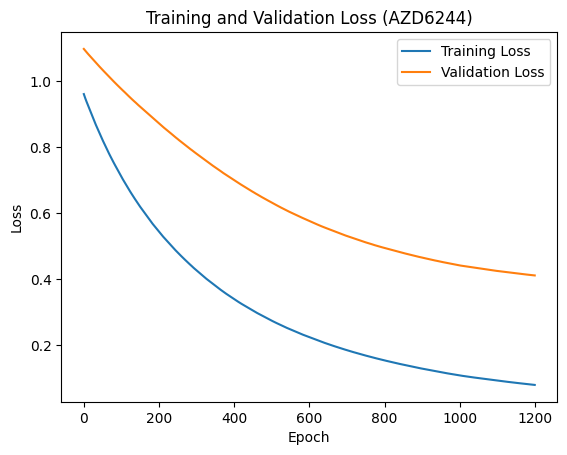

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss (AZD6244)')
ax.legend()

In [ ]:
accuracy = accuracy_score(azd_y_test, binary_predictions)

precision = precision_score(azd_y_test, binary_predictions)

recall = recall_score(azd_y_test, binary_predictions)

f1 = f1_score(azd_y_test, binary_predictions)

conf_matrix = confusion_matrix(azd_y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.703125
Precision: 0.5384615384615384
Recall: 0.35
F1 Score: 0.4242424242424242
Confusion Matrix:
[[38  6]
 [13  7]]


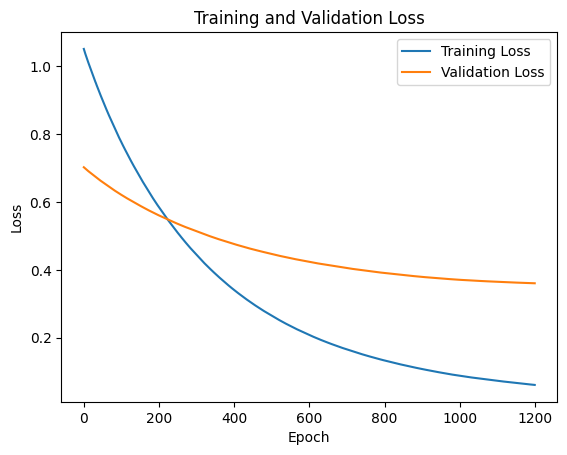

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss (AZD6244)')
ax.legend()

In [ ]:
predictions=model.predict(azd_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [ ]:
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

In [ ]:
accuracy = accuracy_score(azd_y_test, binary_predictions)

precision = precision_score(azd_y_test, binary_predictions)

recall = recall_score(azd_y_test, binary_predictions)

f1 = f1_score(azd_y_test, binary_predictions)

conf_matrix = confusion_matrix(azd_y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.75
Precision: 0.6666666666666666
Recall: 0.4
F1 Score: 0.5
Confusion Matrix:
[[40  4]
 [12  8]]


## PLX4720

In [ ]:
input_shape = plx_train.shape[1]

input_layer = Input(shape=(input_shape,))
x = Dense(64, activation='relu')(input_layer)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

lr = 0.00001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

def lr_scheduler(epoch, lr):
    decay_rate = 0.9  ##Decay rate
    decay_step = 1000  ##Decay step
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

scheduler = LearningRateScheduler(lr_scheduler)

class PrintMSECallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} - loss: {logs['loss']:.4f} - mae: {logs['mae']:.4f} - val_loss: {logs['val_loss']:.4f} - val_mae: {logs['val_mae']:.4f}")

##Train the model
history = model.fit(
    x=plx_train,
    y=plx_y_train,
    epochs=1200,
    batch_size=32,
    validation_data=(plx_val, plx_y_val),
    callbacks=[scheduler, PrintMSECallback()]
)

Epoch 1/1200
1/6 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.5104 - mae: 0.5524Epoch 1 - loss: 0.4929 - mae: 0.5327 - val_loss: 0.4889 - val_mae: 0.5537
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.5178 - mae: 0.5451 - val_loss: 0.4889 - val_mae: 0.5537 - learning_rate: 1.0000e-05
Epoch 2/1200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.4227 - mae: 0.5004Epoch 2 - loss: 0.4904 - mae: 0.5315 - val_loss: 0.4865 - val_mae: 0.5524
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5004 - mae: 0.5219 - val_loss: 0.4865 - val_mae: 0.5524 - learning_rate: 1.0000e-05
Epoch 3/1200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.3807 - mae: 0.5156Epoch 3 - loss: 0.4881 - mae: 0.5303 - val_loss: 0.4842 - val_mae: 0.5512
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5105 - mae: 0.5469 - val_loss: 0.4842 - val_mae: 0.5512 - learning_rate: 1.0000e-05
Epoch 4/1200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.6845 - mae: 0.6293Epoch 4 - loss: 0.4857 - mae: 0.5291 - val_loss: 0.4821 - val_mae: 0

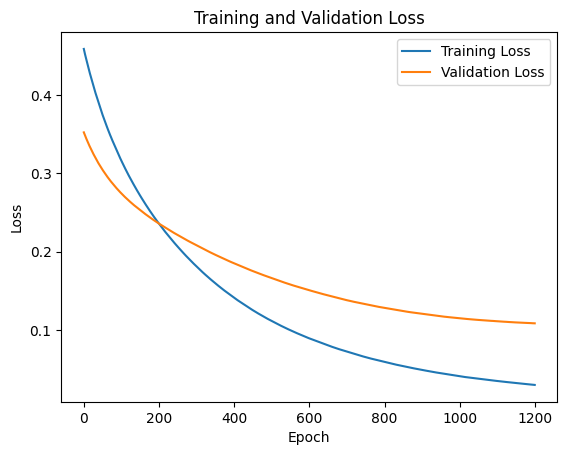

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss (PLX4720)')
ax.legend()

In [ ]:
predictions=model.predict(plx_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


In [ ]:
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

In [ ]:
accuracy = accuracy_score(plx_y_test, binary_predictions)

precision = precision_score(plx_y_test, binary_predictions, zero_division=1)

recall = recall_score(plx_y_test, binary_predictions, zero_division=1)

f1 = f1_score(plx_y_test, binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(plx_y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8125
Precision: 0.6666666666666666
Recall: 0.15384615384615385
F1 Score: 0.25
Confusion Matrix:
[[50  1]
 [11  2]]


##Nilotinib

In [ ]:
input_shape = nil_train.shape[1]

input_layer = Input(shape=(input_shape,))
x = Dense(64, activation='relu')(input_layer)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

lr = 0.00001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

def lr_scheduler(epoch, lr):
    decay_rate = 0.9  ##Decay rate
    decay_step = 1000  ##Decay step
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

scheduler = LearningRateScheduler(lr_scheduler)

class PrintMSECallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} - loss: {logs['loss']:.4f} - mae: {logs['mae']:.4f} - val_loss: {logs['val_loss']:.4f} - val_mae: {logs['val_mae']:.4f}")

##Train the model
history = model.fit(
    x=nil_train,
    y=nil_y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(nil_val, nil_y_val),
    callbacks=[scheduler, PrintMSECallback()]
)

Epoch 1/1000
1/6 ━━━━━━━━━━━━━━━━━━━━ 4s 855ms/step - loss: 0.3865 - mae: 0.4547Epoch 1 - loss: 0.4020 - mae: 0.4841 - val_loss: 0.5468 - val_mae: 0.5190
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.3822 - mae: 0.4649 - val_loss: 0.5468 - val_mae: 0.5190 - learning_rate: 1.0000e-05
Epoch 2/1000
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.4171 - mae: 0.5000Epoch 2 - loss: 0.4001 - mae: 0.4829 - val_loss: 0.5447 - val_mae: 0.5180
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3726 - mae: 0.4744 - val_loss: 0.5447 - val_mae: 0.5180 - learning_rate: 1.0000e-05
Epoch 3/1000
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3104 - mae: 0.4621Epoch 3 - loss: 0.3983 - mae: 0.4818 - val_loss: 0.5425 - val_mae: 0.5170
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3722 - mae: 0.4791 - val_loss: 0.5425 - val_mae: 0.5170 - learning_rate: 1.0000e-05
Epoch 4/1000
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3627 - mae: 0.4126Epoch 4 - loss: 0.3968 - mae: 0.4807 - val_loss: 0.5399 - val_mae: 

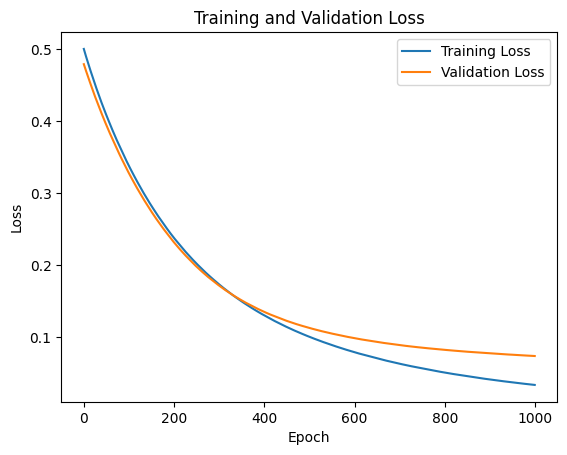

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss (Nilotinib)')
ax.legend()

In [ ]:
predictions2=model.predict(nil_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


In [ ]:
threshold = 0.5
binary_predictions = (predictions2 > threshold).astype(int)

In [ ]:
predictions=model.predict(nil_test)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(nil_y_test, binary_predictions)

precision = precision_score(nil_y_test, binary_predictions)

recall = recall_score(nil_y_test, binary_predictions)

f1 = f1_score(nil_y_test, binary_predictions)

conf_matrix = confusion_matrix(nil_y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 5ms/step
Accuracy: 0.96875
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[62  2]
 [ 0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Sorafenib

In [ ]:
input_shape = sor_train.shape[1]

input_layer = Input(shape=(input_shape,))
x = Dense(64, activation='relu')(input_layer)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

lr = 0.0001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

def lr_scheduler(epoch, lr):
    decay_rate = 0.9  ##Decay rate
    decay_step = 100  ##Decay step
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

scheduler = LearningRateScheduler(lr_scheduler)

class PrintMSECallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} - loss: {logs['loss']:.4f} - mae: {logs['mae']:.4f} - val_loss: {logs['val_loss']:.4f} - val_mae: {logs['val_mae']:.4f}")

##Train the model
history = model.fit(
    x=sor_train,
    y=sor_y_train,
    epochs=250,
    batch_size=32,
    validation_data=(sor_val, sor_y_val),
    callbacks=[scheduler, PrintMSECallback()]
)

Epoch 1/250
1/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 1.0966 - mae: 0.7923Epoch 1 - loss: 0.8329 - mae: 0.6736 - val_loss: 0.9460 - val_mae: 0.7518
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.9021 - mae: 0.7085 - val_loss: 0.9460 - val_mae: 0.7518 - learning_rate: 1.0000e-04
Epoch 2/250
1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - loss: 0.4116 - mae: 0.5144Epoch 2 - loss: 0.7955 - mae: 0.6608 - val_loss: 0.9220 - val_mae: 0.7426
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6372 - mae: 0.6062 - val_loss: 0.9220 - val_mae: 0.7426 - learning_rate: 1.0000e-04
Epoch 3/250
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5481 - mae: 0.5659Epoch 3 - loss: 0.7702 - mae: 0.6515 - val_loss: 0.8971 - val_mae: 0.7327
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7247 - mae: 0.6338 - val_loss: 0.8971 - val_mae: 0.7327 - learning_rate: 1.0000e-04
Epoch 4/250
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.5321 - mae: 0.5644Epoch 4 - loss: 0.7405 - mae: 0.6414 - val_loss: 0.8751 - val_mae: 0.72

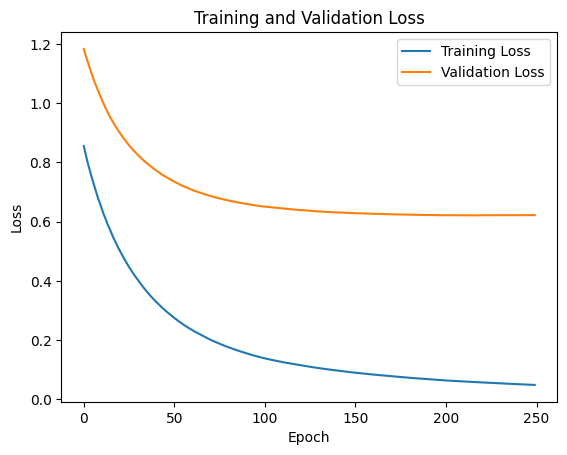

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss (Sorafenib)')
ax.legend()

In [ ]:
predictions=model.predict(sor_test)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(sor_y_test, binary_predictions)

precision = precision_score(sor_y_test, binary_predictions)

recall = recall_score(sor_y_test, binary_predictions)

f1 = f1_score(sor_y_test, binary_predictions)

conf_matrix = confusion_matrix(sor_y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 5ms/step
Accuracy: 0.6875
Precision: 0.13333333333333333
Recall: 0.2222222222222222
F1 Score: 0.16666666666666669
Confusion Matrix:
[[42 13]
 [ 7  2]]


## Paclitaxel

In [ ]:
input_shape = pac_train.shape[1]

input_layer = Input(shape=(input_shape,))
x = Dense(64, activation='relu')(input_layer)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

lr = 0.00001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

def lr_scheduler(epoch, lr):
    decay_rate = 0.9  ##Decay rate
    decay_step = 1000  ##Decay step
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

scheduler = LearningRateScheduler(lr_scheduler)

class PrintMSECallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} - loss: {logs['loss']:.4f} - mae: {logs['mae']:.4f} - val_loss: {logs['val_loss']:.4f} - val_mae: {logs['val_mae']:.4f}")

##Train the model
history = model.fit(
    x=pac_train,
    y=pac_y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(pac_val, pac_y_val),
    callbacks=[scheduler, PrintMSECallback()]
)

Epoch 1/1000
1/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 3.4730 - mae: 1.6367Epoch 1 - loss: 2.8899 - mae: 1.4376 - val_loss: 2.7507 - val_mae: 1.3332
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.0024 - mae: 1.4617 - val_loss: 2.7507 - val_mae: 1.3332 - learning_rate: 1.0000e-05
Epoch 2/1000
1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - loss: 2.2766 - mae: 1.3178Epoch 2 - loss: 2.8792 - mae: 1.4350 - val_loss: 2.7405 - val_mae: 1.3309
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.8140 - mae: 1.4268 - val_loss: 2.7405 - val_mae: 1.3309 - learning_rate: 1.0000e-05
Epoch 3/1000
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.1875 - mae: 1.2421Epoch 3 - loss: 2.8690 - mae: 1.4325 - val_loss: 2.7305 - val_mae: 1.3287
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6072 - mae: 1.3491 - val_loss: 2.7305 - val_mae: 1.3287 - learning_rate: 1.0000e-05
Epoch 4/1000
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2.1843 - mae: 1.1707Epoch 4 - loss: 2.8595 - mae: 1.4301 - val_loss: 2.7203 - val_mae: 

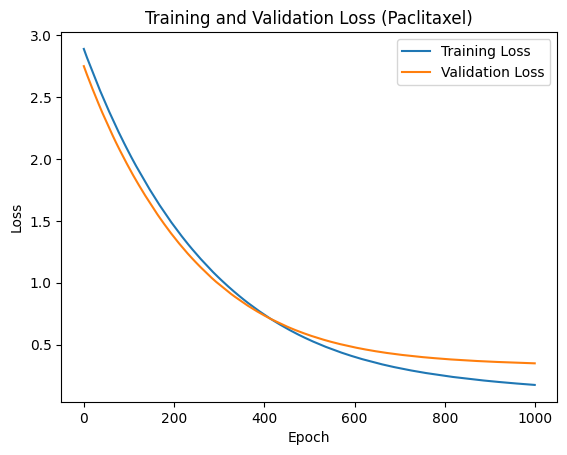

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss (Paclitaxel)')
ax.legend()

In [ ]:
predictions=model.predict(pac_test)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(pac_y_test, binary_predictions)

precision = precision_score(pac_y_test, binary_predictions)

recall = recall_score(pac_y_test, binary_predictions)

f1 = f1_score(pac_y_test, binary_predictions)

conf_matrix = confusion_matrix(pac_y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 7ms/step
Accuracy: 0.53125
Precision: 0.8787878787878788
Recall: 0.5272727272727272
F1 Score: 0.6590909090909091
Confusion Matrix:
[[ 5  4]
 [26 29]]


## Lapatinib

In [ ]:
input_shape = lap_train.shape[1]

input_layer = Input(shape=(input_shape,))
x = Dense(64, activation='relu')(input_layer)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

lr = 0.00001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

def lr_scheduler(epoch, lr):
    decay_rate = 0.9  ##Decay rate
    decay_step = 1000  ##Decay step
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

scheduler = LearningRateScheduler(lr_scheduler)

class PrintMSECallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} - loss: {logs['loss']:.4f} - mae: {logs['mae']:.4f} - val_loss: {logs['val_loss']:.4f} - val_mae: {logs['val_mae']:.4f}")

##Train the model
history = model.fit(
    x=lap_train,
    y=lap_y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(lap_val, lap_y_val),
    callbacks=[scheduler, PrintMSECallback()]
)

Epoch 1/1000
1/6 ━━━━━━━━━━━━━━━━━━━━ 4s 844ms/step - loss: 0.9681 - mae: 0.6544Epoch 1 - loss: 0.7706 - mae: 0.6202 - val_loss: 0.8690 - val_mae: 0.6729
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.8516 - mae: 0.6253 - val_loss: 0.8690 - val_mae: 0.6729 - learning_rate: 1.0000e-05
Epoch 2/1000
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.9777 - mae: 0.6873Epoch 2 - loss: 0.7645 - mae: 0.6183 - val_loss: 0.8640 - val_mae: 0.6710
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7600 - mae: 0.6205 - val_loss: 0.8640 - val_mae: 0.6710 - learning_rate: 1.0000e-05
Epoch 3/1000
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3753 - mae: 0.5080Epoch 3 - loss: 0.7588 - mae: 0.6161 - val_loss: 0.8591 - val_mae: 0.6691
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7245 - mae: 0.6288 - val_loss: 0.8591 - val_mae: 0.6691 - learning_rate: 1.0000e-05
Epoch 4/1000
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4408 - mae: 0.5196Epoch 4 - loss: 0.7528 - mae: 0.6139 - val_loss: 0.8544 - val_mae: 

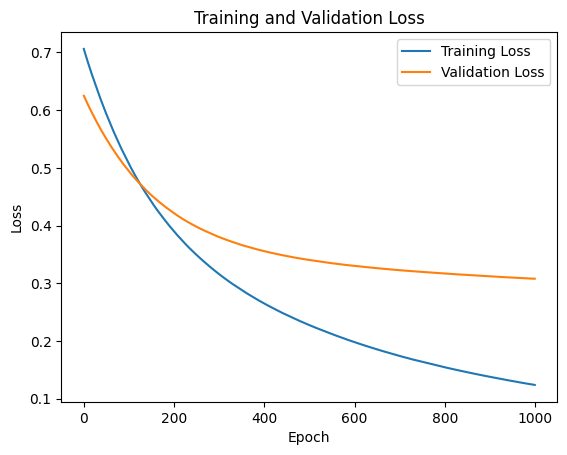

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss (Lapatinib)')
ax.legend()

In [ ]:
predictions=model.predict(lap_test)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(lap_y_test, binary_predictions)

precision = precision_score(lap_y_test, binary_predictions)

recall = recall_score(lap_y_test, binary_predictions)

f1 = f1_score(lap_y_test, binary_predictions)

conf_matrix = confusion_matrix(lap_y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 5ms/step
Accuracy: 0.8125
Precision: 0.15384615384615385
Recall: 0.6666666666666666
F1 Score: 0.25
Confusion Matrix:
[[50 11]
 [ 1  2]]


## Erlotinib

In [ ]:
input_shape = erl_train.shape[1]

input_layer = Input(shape=(input_shape,))
x = Dense(64, activation='relu')(input_layer)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

lr = 0.00001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

def lr_scheduler(epoch, lr):
    decay_rate = 0.9  ##Decay rate
    decay_step = 1000  ##Decay step
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

scheduler = LearningRateScheduler(lr_scheduler)

class PrintMSECallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} - loss: {logs['loss']:.4f} - mae: {logs['mae']:.4f} - val_loss: {logs['val_loss']:.4f} - val_mae: {logs['val_mae']:.4f}")

##Train the model
history = model.fit(
    x=erl_train,
    y=erl_y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(erl_val, erl_y_val),
    callbacks=[scheduler, PrintMSECallback()]
)

Epoch 1/1000
6/6 [==============================] - 2s 90ms/step - loss: 0.7761 - mae: 0.6902 - val_loss: 0.5976 - val_mae: 0.6107 - lr: 1.0000e-05
Epoch 2/1000
6/6 [==============================] - 0s 22ms/step - loss: 0.7728 - mae: 0.6887 - val_loss: 0.5956 - val_mae: 0.6098 - lr: 1.0000e-05
Epoch 3/1000
6/6 [==============================] - 0s 26ms/step - loss: 0.7695 - mae: 0.6871 - val_loss: 0.5937 - val_mae: 0.6088 - lr: 1.0000e-05
Epoch 4/1000
6/6 [==============================] - 0s 21ms/step - loss: 0.7664 - mae: 0.6856 - val_loss: 0.5917 - val_mae: 0.6079 - lr: 1.0000e-05
Epoch 5/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.7632 - mae: 0.6840 - val_loss: 0.5898 - val_mae: 0.6069 - lr: 1.0000e-05
Epoch 6/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.7601 - mae: 0.6825 - val_loss: 0.5879 - val_mae: 0.6060 - lr: 1.0000e-05
Epoch 7/1000
6/6 [==============================] - 0s 19ms/step - loss: 0.7570 - mae: 0.6809 - val_loss: 0.5860

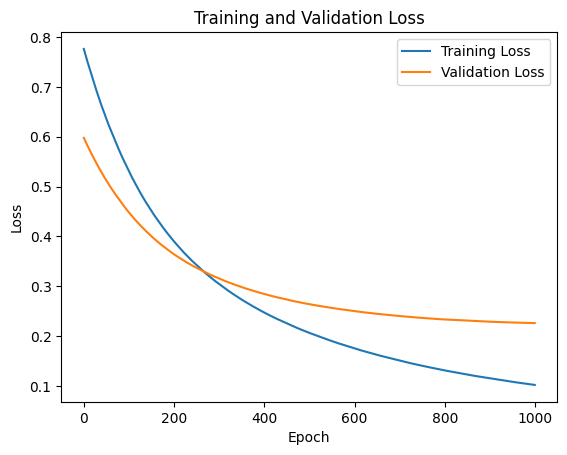

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss (Erlotinib)')
ax.legend()

In [ ]:
predictions=model.predict(erl_test)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(erl_y_test, binary_predictions)

precision = precision_score(erl_y_test, binary_predictions)

recall = recall_score(erl_y_test, binary_predictions)

f1 = f1_score(erl_y_test, binary_predictions)

conf_matrix = confusion_matrix(erl_y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 8ms/step
Accuracy: 0.828125
Precision: 0.2
Recall: 0.125
F1 Score: 0.15384615384615385
Confusion Matrix:
[[52  4]
 [ 7  1]]


# Add Attention

## Prepare TCGA Data

In [ ]:
##Take copy of data from earlier
all_y_dummy_gdsc=all_y_dummy_gdsc.sort_index()

In [ ]:
##Split GDSC into training and validation data
##Cannot use CCLE data as it does not contain the drugs common with TCGA
y_gdsc_train, y_gdsc_val=train_test_split(all_y_dummy_gdsc, test_size=0.3, random_state=0)
gdsc_train, gdsc_val=train_test_split(all_gdsc, test_size=0.3, random_state=0)

In [ ]:
def feature_df_gdsc(drug_name, y_gdsc_train=y_gdsc_train, y_gdsc_val=y_gdsc_val, gdsc_train=gdsc_train, gdsc_val=gdsc_val):
    data_suffix = {1: "_cnv", 2: "_crispr", 3: "_meth", 4: "_mrna", 5: "_mut"}

    ##Initialize an empty list to store results
    result_list = []

    ##Iterate over each row in the dataframe
    for index, row in features.iterrows():
        if row['medi'] == drug_name:
            ##Construct the desired string
            suffix = data_suffix[row['data_num']]
            result_string = f"{row['gen_name']}{suffix}"

            ##Append to the result list
            result_list.append(result_string)

    non_null_train = y_gdsc_train[drug_name].dropna().index
    non_null_val = y_gdsc_val[drug_name].dropna().index

    y_train = y_gdsc_train.loc[non_null_train, drug_name]
    y_val = y_gdsc_val.loc[non_null_val, drug_name]

    new_gdsc_train = gdsc_train.loc[non_null_train]
    new_gdsc_val = gdsc_val.loc[non_null_val]

    cols_to_drop = [col for col in gdsc_train.columns if col not in result_list]
    new_gdsc_train = new_gdsc_train.drop(columns=cols_to_drop)
    new_gdsc_val = new_gdsc_val.drop(columns=cols_to_drop)

    new_gdsc_train.fillna(0, inplace=True)
    new_gdsc_val.fillna(0, inplace=True)


    return new_gdsc_train, new_gdsc_val, y_train, y_val

In [ ]:
##Prepare TCGA data
cis_train, cis_val, cis_y_train, cis_y_val=feature_df_gdsc("Cisplatin")
flu_train, flu_val, flu_y_train, flu_y_val=feature_df_gdsc("5-Fluorouracil")
gem_train, gem_val, gem_y_train, gem_y_val=feature_df_gdsc("Gemcitabine")

In [ ]:
##Prepare the training and testing datasets
mut_columns = [col for col in cis_tcga.columns if col.endswith('_mut')]
cnv_columns = [col for col in cis_tcga.columns if col.endswith('_cnv')]
meth_columns = [col for col in cis_tcga.columns if col.endswith('_meth')]
mrna_columns = [col for col in cis_tcga.columns if col.endswith('_mrna')]

cis_train_mut = cis_train[mut_columns]
cis_train_cnv = cis_train[cnv_columns]
cis_train_meth = cis_train[meth_columns]
cis_train_mrna = cis_train[mrna_columns]

cis_val_mut = cis_val[mut_columns]
cis_val_cnv = cis_val[cnv_columns]
cis_val_meth = cis_val[meth_columns]
cis_val_mrna = cis_val[mrna_columns]

cis_test_mut = cis_tcga[mut_columns]
cis_test_cnv = cis_tcga[cnv_columns]
cis_test_meth = cis_tcga[meth_columns]
cis_test_mrna = cis_tcga[mrna_columns]

cis_train_labels = cis_y_train
cis_val_labels = cis_y_val

In [ ]:
##Prepare the training and testing datasets
mut_columns = [col for col in flu_tcga.columns if col.endswith('_mut')]
cnv_columns = [col for col in flu_tcga.columns if col.endswith('_cnv')]
meth_columns = [col for col in flu_tcga.columns if col.endswith('_meth')]
mrna_columns = [col for col in flu_tcga.columns if col.endswith('_mrna')]

flu_train_mut = flu_train[mut_columns]
flu_train_cnv = flu_train[cnv_columns]
flu_train_meth = flu_train[meth_columns]
flu_train_mrna = flu_train[mrna_columns]

flu_val_mut = flu_val[mut_columns]
flu_val_cnv = flu_val[cnv_columns]
flu_val_meth = flu_val[meth_columns]
flu_val_mrna = flu_val[mrna_columns]

flu_test_mut = flu_tcga[mut_columns]
flu_test_cnv = flu_tcga[cnv_columns]
flu_test_meth = flu_tcga[meth_columns]
flu_test_mrna = flu_tcga[mrna_columns]

flu_train_labels = flu_y_train
flu_val_labels = flu_y_val

In [ ]:
##Prepare the training and testing datasets
mut_columns = [col for col in gem_tcga.columns if col.endswith('_mut')]
cnv_columns = [col for col in gem_tcga.columns if col.endswith('_cnv')]
meth_columns = [col for col in gem_tcga.columns if col.endswith('_meth')]
mrna_columns = [col for col in gem_tcga.columns if col.endswith('_mrna')]

gem_train_mut = gem_train[mut_columns]
gem_train_cnv = gem_train[cnv_columns]
gem_train_meth = gem_train[meth_columns]
gem_train_mrna = gem_train[mrna_columns]

gem_val_mut = gem_val[mut_columns]
gem_val_cnv = gem_val[cnv_columns]
gem_val_meth = gem_val[meth_columns]
gem_val_mrna = gem_val[mrna_columns]

gem_test_mut = gem_tcga[mut_columns]
gem_test_cnv = gem_tcga[cnv_columns]
gem_test_meth = gem_tcga[meth_columns]
gem_test_mrna = gem_tcga[mrna_columns]

gem_train_labels = gem_y_train
gem_val_labels = gem_y_val

In [ ]:
cis_test_mut=cis_test_mut.fillna(0)
gem_test_mut=gem_test_mut.fillna(0)
flu_test_mut=flu_test_mut.fillna(0)

## Control

In [ ]:
##Prepare the training and testing datasets
mut_columns = [col for col in azd_train.columns if col.endswith('_mut')]
cnv_columns = [col for col in azd_train.columns if col.endswith('_cnv')]
meth_columns = [col for col in azd_train.columns if col.endswith('_meth')]
mrna_columns = [col for col in azd_train.columns if col.endswith('_mrna')]

input_mut_shape = azd_train[mut_columns].shape[1]
input_cnv_shape = azd_train[cnv_columns].shape[1]
input_meth_shape = azd_train[meth_columns].shape[1]
input_mrna_shape = azd_train[mrna_columns].shape[1]

train_mut = azd_train[mut_columns]
train_cnv = azd_train[cnv_columns]
train_meth = azd_train[meth_columns]
train_mrna = azd_train[mrna_columns]

val_mut = azd_val[mut_columns]
val_cnv = azd_val[cnv_columns]
val_meth = azd_val[meth_columns]
val_mrna = azd_val[mrna_columns]

train_labels = azd_y_train
val_labels = azd_y_val

In [ ]:
##Input layers
input_mut = Input(shape=(input_mut_shape,), name='mut_input')
input_cnv = Input(shape=(input_cnv_shape,), name='cnv_input')
input_meth = Input(shape=(input_meth_shape,), name='meth_input')
input_mrna = Input(shape=(input_mrna_shape,), name='mrna_input')

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([input_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.000001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 1000
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[train_mut, train_cnv, train_meth, train_mrna],
    y=azd_y_train,
    epochs=1000,
    batch_size=1,
    validation_data=([val_mut, val_cnv, val_meth, val_mrna], azd_y_val),
    callbacks=[scheduler]
)

Epoch 1/1000
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6567 - mae: 0.4652 - val_loss: 0.7345 - val_mae: 0.4898 - learning_rate: 1.0000e-06
Epoch 2/1000
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6707 - mae: 0.4709 - val_loss: 0.7338 - val_mae: 0.4895 - learning_rate: 1.0000e-06
Epoch 3/1000
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6897 - mae: 0.4837 - val_loss: 0.7330 - val_mae: 0.4891 - learning_rate: 1.0000e-06
Epoch 4/1000
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6590 - mae: 0.4673 - val_loss: 0.7323 - val_mae: 0.4888 - learning_rate: 1.0000e-06
Epoch 5/1000
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6377 - mae: 0.4572 - val_loss: 0.7315 - val_mae: 0.4885 - learning_rate: 1.0000e-06
Epoch 6/1000
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6588 - mae: 0.4685 - val_loss: 0.7308 - val_mae: 0.4881 - learning_rate: 1.0000e-06
Epoch 7/1000
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6621 - mae: 0.4681 - val_loss: 0.7300 - val_mae:

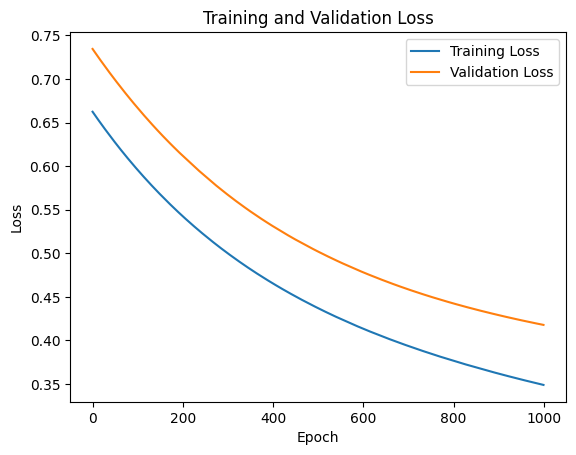

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss')
ax.legend()

In [ ]:
test_mut = azd_test[mut_columns]
test_cnv = azd_test[cnv_columns]
test_meth = azd_test[meth_columns]
test_mrna = azd_test[mrna_columns]

In [ ]:
predictions=model.predict([test_mut, test_cnv, test_meth, test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(azd_y_test, binary_predictions)

precision = precision_score(azd_y_test, binary_predictions, zero_division=1)

recall = recall_score(azd_y_test, binary_predictions, zero_division=1)

f1 = f1_score(azd_y_test, binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(azd_y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
Accuracy: 0.65625
Precision: 0.3333333333333333
Recall: 0.1
F1 Score: 0.15384615384615383
Confusion Matrix:
[[40  4]
 [18  2]]


### Cisplatin

In [ ]:
##Input layers
input_mut = Input(shape=(cis_train_mut.shape[1],), name='mut_input')
input_cnv = Input(shape=(cis_train_cnv.shape[1],), name='cnv_input')
input_meth = Input(shape=(cis_train_meth.shape[1],), name='meth_input')
input_mrna = Input(shape=(cis_train_mrna.shape[1],), name='mrna_input')


##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([input_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.0001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 1000
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[cis_train_mut, cis_train_cnv, cis_train_meth, cis_train_mrna],
    y=cis_train_labels,
    epochs=500,
    batch_size=1,
    validation_data=([cis_val_mut, cis_val_cnv, cis_val_meth, cis_val_mrna], cis_val_labels),
    callbacks=[scheduler]
)

Epoch 1/500
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.6928 - mae: 0.4998 - val_loss: 0.6925 - val_mae: 0.4997 - learning_rate: 1.0000e-04
Epoch 2/500
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6918 - mae: 0.4993 - val_loss: 0.6919 - val_mae: 0.4993 - learning_rate: 1.0000e-04
Epoch 3/500
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6908 - mae: 0.4988 - val_loss: 0.6912 - val_mae: 0.4990 - learning_rate: 1.0000e-04
Epoch 4/500
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6903 - mae: 0.4986 - val_loss: 0.6906 - val_mae: 0.4987 - learning_rate: 1.0000e-04
Epoch 5/500
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6883 - mae: 0.4975 - val_loss: 0.6900 - val_mae: 0.4984 - learning_rate: 1.0000e-04
Epoch 6/500
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6881 - mae: 0.4974 - val_loss: 0.6894 - val_mae: 0.4981 - learning_rate: 1.0000e-04
Epoch 7/500
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6863 - mae: 0.4965 - val_loss: 0.6888 - val_mae: 0.4978 - learning_r

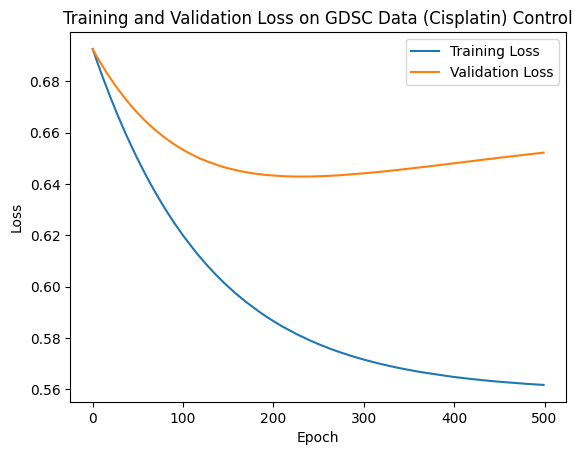

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss on GDSC Data (Cisplatin) Control')
ax.legend()

In [ ]:
cis_test_mut=cis_test_mut.fillna(0)
cis_test_cnv=cis_test_cnv.fillna(0)
cis_test_meth=cis_test_meth.fillna(0)
cis_test_mrna=cis_test_mrna.fillna(0)
cis_test_mut = cis_test_mut.apply(lambda x: (x-x.mean())/x.std(),axis=0)
cis_test_cnv = cis_test_cnv.apply(lambda x: (x-x.mean())/x.std(),axis=0)
cis_test_meth = cis_test_meth.apply(lambda x: (x-x.mean())/x.std(),axis=0)
cis_test_mrna = cis_test_mrna.apply(lambda x: (x-x.mean())/x.std(),axis=0)

In [ ]:
predictions=model.predict([cis_test_mut, cis_test_cnv, cis_test_meth, cis_test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(cis_y["measure_of_response"], binary_predictions)

precision = precision_score(cis_y["measure_of_response"], binary_predictions, zero_division=1)

recall = recall_score(cis_y["measure_of_response"], binary_predictions, zero_division=1)

f1 = f1_score(cis_y["measure_of_response"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(cis_y["measure_of_response"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Accuracy: 0.7346938775510204
Precision: 0.7346938775510204
Recall: 1.0
F1 Score: 0.8470588235294119
Confusion Matrix:
[[ 0 13]
 [ 0 36]]


In [ ]:
accuracy = accuracy_score(cis_y["Overall Survival Status"], binary_predictions)

precision = precision_score(cis_y["Overall Survival Status"], binary_predictions, zero_division=1)

recall = recall_score(cis_y["Overall Survival Status"], binary_predictions, zero_division=1)

f1 = f1_score(cis_y["Overall Survival Status"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(cis_y["Overall Survival Status"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7551020408163265
Precision: 0.7551020408163265
Recall: 1.0
F1 Score: 0.8604651162790697
Confusion Matrix:
[[ 0 12]
 [ 0 37]]


### 5-Fluorouracil

In [ ]:
##Input layers
input_mut = Input(shape=(flu_train_mut.shape[1],), name='mut_input')
input_cnv = Input(shape=(flu_train_cnv.shape[1],), name='cnv_input')
input_meth = Input(shape=(flu_train_meth.shape[1],), name='meth_input')
input_mrna = Input(shape=(flu_train_mrna.shape[1],), name='mrna_input')

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([input_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.0001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 1000
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[flu_train_mut, flu_train_cnv, flu_train_meth, flu_train_mrna],
    y=flu_train_labels,
    epochs=300,
    batch_size=1,
    validation_data=([flu_val_mut, flu_val_cnv, flu_val_meth, flu_val_mrna], flu_val_labels),
    callbacks=[scheduler]
)

Epoch 1/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.6932 - mae: 0.5000 - val_loss: 0.6930 - val_mae: 0.4999 - learning_rate: 1.0000e-04
Epoch 2/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6928 - mae: 0.4998 - val_loss: 0.6929 - val_mae: 0.4999 - learning_rate: 1.0000e-04
Epoch 3/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6930 - mae: 0.4999 - val_loss: 0.6928 - val_mae: 0.4998 - learning_rate: 1.0000e-04
Epoch 4/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6920 - mae: 0.4994 - val_loss: 0.6926 - val_mae: 0.4997 - learning_rate: 1.0000e-04
Epoch 5/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6923 - mae: 0.4996 - val_loss: 0.6925 - val_mae: 0.4997 - learning_rate: 1.0000e-04
Epoch 6/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6916 - mae: 0.4992 - val_loss: 0.6924 - val_mae: 0.4996 - learning_rate: 1.0000e-04
Epoch 7/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6914 - mae: 0.4991 - val_loss: 0.6923 - val_mae: 0.4995 - learning_r

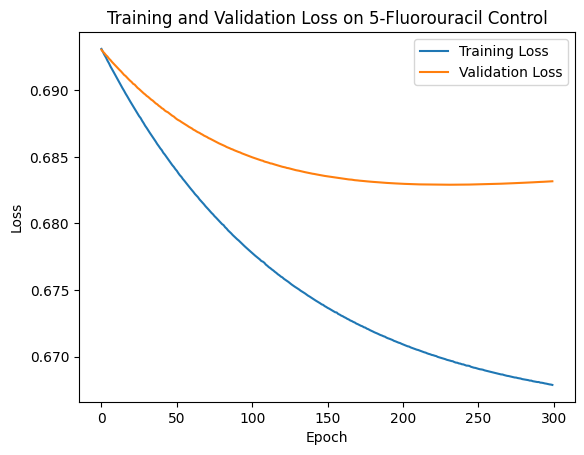

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss on 5-Fluorouracil Control')
ax.legend()

In [ ]:
predictions=model.predict([flu_test_mut, flu_test_cnv, flu_test_meth, flu_test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(flu_y["measure_of_response"], binary_predictions)

precision = precision_score(flu_y["measure_of_response"], binary_predictions, zero_division=1)

recall = recall_score(flu_y["measure_of_response"], binary_predictions, zero_division=1)

f1 = f1_score(flu_y["measure_of_response"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(flu_y["measure_of_response"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[21  0]
 [42  0]]


In [ ]:
accuracy = accuracy_score(flu_y["Overall Survival Status"], binary_predictions)

precision = precision_score(flu_y["Overall Survival Status"], binary_predictions, zero_division=1)

recall = recall_score(flu_y["Overall Survival Status"], binary_predictions, zero_division=1)

f1 = f1_score(flu_y["Overall Survival Status"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(flu_y["Overall Survival Status"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5079365079365079
Precision: 1.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[32  0]
 [31  0]]


### Gemcitabine

In [ ]:
##Input layers
input_mut = Input(shape=(gem_train_mut.shape[1],), name='mut_input')
input_cnv = Input(shape=(gem_train_cnv.shape[1],), name='cnv_input')
input_meth = Input(shape=(gem_train_meth.shape[1],), name='meth_input')
input_mrna = Input(shape=(gem_train_mrna.shape[1],), name='mrna_input')

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([input_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.0001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 1000
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[gem_train_mut, gem_train_cnv, gem_train_meth, gem_train_mrna],
    y=gem_train_labels,
    epochs=500,
    batch_size=1,
    validation_data=([gem_val_mut, gem_val_cnv, gem_val_meth, gem_val_mrna], gem_val_labels),
    callbacks=[scheduler]
)

Epoch 1/500
81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 0.6931 - mae: 0.5000 - val_loss: 0.6928 - val_mae: 0.4998 - learning_rate: 1.0000e-04
Epoch 2/500
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6928 - mae: 0.4998 - val_loss: 0.6923 - val_mae: 0.4996 - learning_rate: 1.0000e-04
Epoch 3/500
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6928 - mae: 0.4998 - val_loss: 0.6919 - val_mae: 0.4994 - learning_rate: 1.0000e-04
Epoch 4/500
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6927 - mae: 0.4998 - val_loss: 0.6915 - val_mae: 0.4992 - learning_rate: 1.0000e-04
Epoch 5/500
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6921 - mae: 0.4995 - val_loss: 0.6911 - val_mae: 0.4990 - learning_rate: 1.0000e-04
Epoch 6/500
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6920 - mae: 0.4994 - val_loss: 0.6907 - val_mae: 0.4988 - learning_rate: 1.0000e-04
Epoch 7/500
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6918 - mae: 0.4993 - val_loss: 0.6902 - val_mae: 0.4985 - learning_r

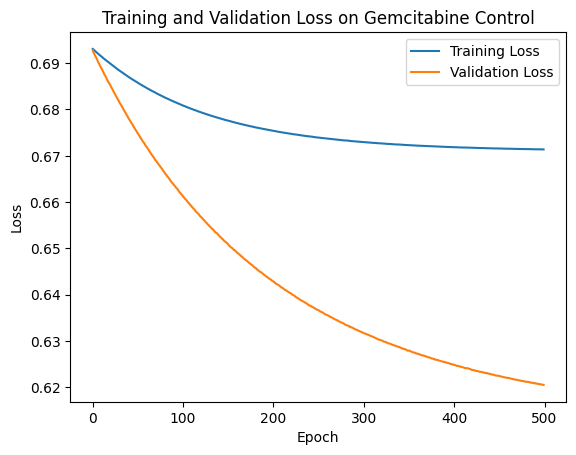

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss on Gemcitabine Control')
ax.legend()

In [ ]:
predictions=model.predict([gem_test_mut, gem_test_cnv, gem_test_meth, gem_test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(gem_y["measure_of_response"], binary_predictions)

precision = precision_score(gem_y["measure_of_response"], binary_predictions, zero_division=1)

recall = recall_score(gem_y["measure_of_response"], binary_predictions, zero_division=1)

f1 = f1_score(gem_y["measure_of_response"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(gem_y["measure_of_response"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Accuracy: 0.44642857142857145
Precision: 0.44642857142857145
Recall: 1.0
F1 Score: 0.617283950617284
Confusion Matrix:
[[ 0 31]
 [ 0 25]]


In [ ]:
accuracy = accuracy_score(gem_y["Overall Survival Status"], binary_predictions)

precision = precision_score(gem_y["Overall Survival Status"], binary_predictions, zero_division=1)

recall = recall_score(gem_y["Overall Survival Status"], binary_predictions, zero_division=1)

f1 = f1_score(gem_y["Overall Survival Status"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(gem_y["Overall Survival Status"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.4107142857142857
Precision: 0.4107142857142857
Recall: 1.0
F1 Score: 0.5822784810126582
Confusion Matrix:
[[ 0 33]
 [ 0 23]]


## On Mutation

In [ ]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu)
        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), 1)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [ ]:
##Prepare the training and testing datasets
mut_columns = [col for col in azd_train.columns if col.endswith('_mut')]
cnv_columns = [col for col in azd_train.columns if col.endswith('_cnv')]
meth_columns = [col for col in azd_train.columns if col.endswith('_meth')]
mrna_columns = [col for col in azd_train.columns if col.endswith('_mrna')]

input_mut_shape = azd_train[mut_columns].shape[1]
input_cnv_shape = azd_train[cnv_columns].shape[1]
input_meth_shape = azd_train[meth_columns].shape[1]
input_mrna_shape = azd_train[mrna_columns].shape[1]

train_mut = azd_train[mut_columns]
train_cnv = azd_train[cnv_columns]
train_meth = azd_train[meth_columns]
train_mrna = azd_train[mrna_columns]

val_mut = azd_val[mut_columns]
val_cnv = azd_val[cnv_columns]
val_meth = azd_val[meth_columns]
val_mrna = azd_val[mrna_columns]

train_labels = azd_y_train
val_labels = azd_y_val

In [ ]:
##Input layers
input_mut = Input(shape=(input_mut_shape,), name='mut_input')
input_cnv = Input(shape=(input_cnv_shape,), name='cnv_input')
input_meth = Input(shape=(input_meth_shape,), name='meth_input')
input_mrna = Input(shape=(input_mrna_shape,), name='mrna_input')

##Apply attention to the mutation input only
attention_mut = Attention()(tf.expand_dims(input_mut, axis=1))

##Flatten the attention output
flatten_mut = Flatten()(attention_mut)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([flatten_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.000001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 1000
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)


In [ ]:
##Train the model
history = model.fit(
    x=[train_mut, train_cnv, train_meth, train_mrna],
    y=azd_y_train,
    epochs=1000,
    batch_size=1,
    validation_data=([val_mut, val_cnv, val_meth, val_mrna], azd_y_val),
    callbacks=[scheduler]
)


Epoch 1/1000
184/184 [==============================] - 4s 7ms/step - loss: 0.6870 - mae: 0.4628 - val_loss: 0.7264 - val_mae: 0.4736 - lr: 1.0000e-06
Epoch 2/1000
184/184 [==============================] - 0s 3ms/step - loss: 0.6865 - mae: 0.4625 - val_loss: 0.7260 - val_mae: 0.4734 - lr: 1.0000e-06
Epoch 3/1000
184/184 [==============================] - 1s 3ms/step - loss: 0.6859 - mae: 0.4622 - val_loss: 0.7256 - val_mae: 0.4732 - lr: 1.0000e-06
Epoch 4/1000
184/184 [==============================] - 1s 3ms/step - loss: 0.6853 - mae: 0.4619 - val_loss: 0.7252 - val_mae: 0.4730 - lr: 1.0000e-06
Epoch 5/1000
184/184 [==============================] - 0s 3ms/step - loss: 0.6848 - mae: 0.4616 - val_loss: 0.7248 - val_mae: 0.4728 - lr: 1.0000e-06
Epoch 6/1000
184/184 [==============================] - 1s 3ms/step - loss: 0.6842 - mae: 0.4613 - val_loss: 0.7244 - val_mae: 0.4726 - lr: 1.0000e-06
Epoch 7/1000
184/184 [==============================] - 1s 3ms/step - loss: 0.6836 - mae: 0.46

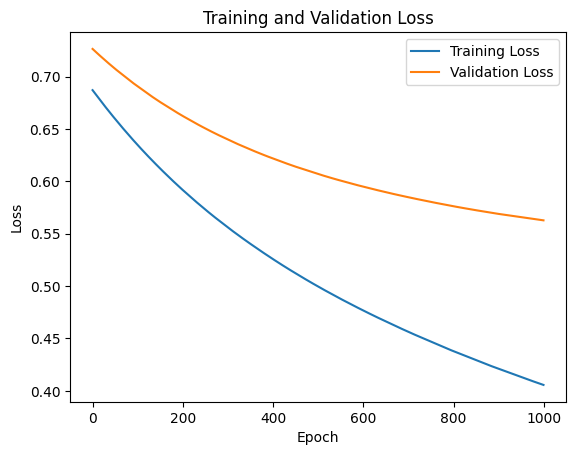

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss')
ax.legend()

In [ ]:
test_mut = azd_test[mut_columns]
test_cnv = azd_test[cnv_columns]
test_meth = azd_test[meth_columns]
test_mrna = azd_test[mrna_columns]

In [ ]:
predictions=model.predict([test_mut, test_cnv, test_meth, test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(azd_y_test, binary_predictions)

precision = precision_score(azd_y_test, binary_predictions, zero_division=1)

recall = recall_score(azd_y_test, binary_predictions, zero_division=1)

f1 = f1_score(azd_y_test, binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(azd_y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 5ms/step
Accuracy: 0.703125
Precision: 1.0
Recall: 0.05
F1 Score: 0.09523809523809523
Confusion Matrix:
[[44  0]
 [19  1]]


### TCGA

In [ ]:
##Input layers
input_mut = Input(shape=(cis_train_mut.shape[1],), name='mut_input')
input_cnv = Input(shape=(cis_train_cnv.shape[1],), name='cnv_input')
input_meth = Input(shape=(cis_train_meth.shape[1],), name='meth_input')
input_mrna = Input(shape=(cis_train_mrna.shape[1],), name='mrna_input')

##Apply attention to the mutation input only
attention_mut = Attention()(tf.expand_dims(input_mut, axis=1))

##Flatten the attention output
flatten_mut = Flatten()(attention_mut)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([flatten_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.000001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 1000
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

#### Cisplatin

In [ ]:
##Train the model
history = model.fit(
    x=[cis_train_mut, cis_train_cnv, cis_train_meth, cis_train_mrna],
    y=cis_train_labels,
    epochs=1000,
    batch_size=1,
    validation_data=([cis_val_mut, cis_val_cnv, cis_val_meth, cis_val_mrna], cis_val_labels),
    callbacks=[scheduler]
)

Epoch 1/1000
81/81 [==============================] - 2s 6ms/step - loss: 0.8693 - mae: 0.5409 - val_loss: 0.8266 - val_mae: 0.5270 - lr: 1.0000e-06
Epoch 2/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.8684 - mae: 0.5406 - val_loss: 0.8260 - val_mae: 0.5268 - lr: 1.0000e-06
Epoch 3/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.8675 - mae: 0.5403 - val_loss: 0.8256 - val_mae: 0.5266 - lr: 1.0000e-06
Epoch 4/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.8667 - mae: 0.5400 - val_loss: 0.8250 - val_mae: 0.5264 - lr: 1.0000e-06
Epoch 5/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.8658 - mae: 0.5398 - val_loss: 0.8245 - val_mae: 0.5263 - lr: 1.0000e-06
Epoch 6/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.8649 - mae: 0.5395 - val_loss: 0.8240 - val_mae: 0.5261 - lr: 1.0000e-06
Epoch 7/1000
81/81 [==============================] - 0s 4ms/step - loss: 0.8641 - mae: 0.5392 - val_loss:

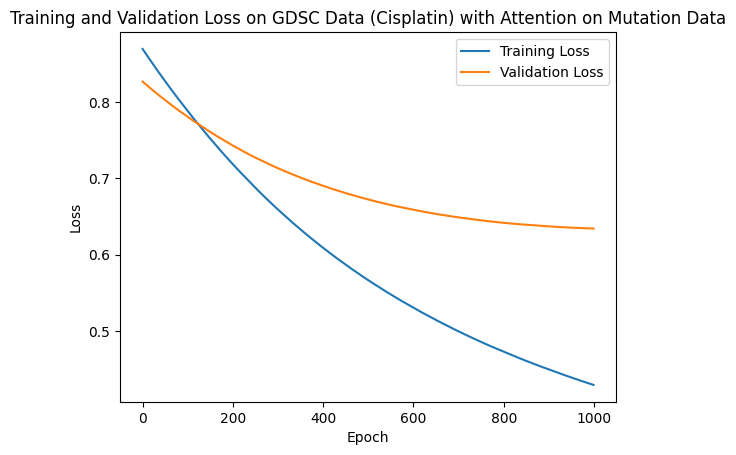

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss on GDSC Data (Cisplatin) with Attention on Mutation Data')
ax.legend()

In [ ]:
cis_test_mut=cis_test_mut.fillna(0)
cis_test_cnv=cis_test_cnv.fillna(0)
cis_test_meth=cis_test_meth.fillna(0)
cis_test_mrna=cis_test_mrna.fillna(0)
cis_test_mut = cis_test_mut.apply(lambda x: (x-x.mean())/x.std(),axis=0)
cis_test_cnv = cis_test_cnv.apply(lambda x: (x-x.mean())/x.std(),axis=0)
cis_test_meth = cis_test_meth.apply(lambda x: (x-x.mean())/x.std(),axis=0)
cis_test_mrna = cis_test_mrna.apply(lambda x: (x-x.mean())/x.std(),axis=0)

In [ ]:
predictions=model.predict([cis_test_mut, cis_test_cnv, cis_test_meth, cis_test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(cis_y["measure_of_response"], binary_predictions)

precision = precision_score(cis_y["measure_of_response"], binary_predictions, zero_division=1)

recall = recall_score(cis_y["measure_of_response"], binary_predictions, zero_division=1)

f1 = f1_score(cis_y["measure_of_response"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(cis_y["measure_of_response"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 5ms/step
Accuracy: 0.673469387755102
Precision: 0.7631578947368421
Recall: 0.8055555555555556
F1 Score: 0.7837837837837838
Confusion Matrix:
[[ 4  9]
 [ 7 29]]


In [ ]:
accuracy = accuracy_score(cis_y["Overall Survival Status"], binary_predictions)

precision = precision_score(cis_y["Overall Survival Status"], binary_predictions, zero_division=1)

recall = recall_score(cis_y["Overall Survival Status"], binary_predictions, zero_division=1)

f1 = f1_score(cis_y["Overall Survival Status"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(cis_y["Overall Survival Status"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7346938775510204
Precision: 0.8157894736842105
Recall: 0.8378378378378378
F1 Score: 0.8266666666666665
Confusion Matrix:
[[ 5  7]
 [ 6 31]]


#### 5-Fluorouracil

In [ ]:
##Input layers
input_mut = Input(shape=(flu_train_mut.shape[1],), name='mut_input')
input_cnv = Input(shape=(flu_train_cnv.shape[1],), name='cnv_input')
input_meth = Input(shape=(flu_train_meth.shape[1],), name='meth_input')
input_mrna = Input(shape=(flu_train_mrna.shape[1],), name='mrna_input')

##Apply attention to the mutation input only
attention_mut = Attention()(tf.expand_dims(input_mut, axis=1))

##Flatten the attention output
flatten_mut = Flatten()(attention_mut)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([flatten_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.000001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 1000
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[flu_train_mut, flu_train_cnv, flu_train_meth, flu_train_mrna],
    y=flu_train_labels,
    epochs=1000,
    batch_size=1,
    validation_data=([flu_val_mut, flu_val_cnv, flu_val_meth, flu_val_mrna], flu_val_labels),
    callbacks=[scheduler]
)

Epoch 1/1000
81/81 [==============================] - 1s 6ms/step - loss: 0.9354 - mae: 0.5065 - val_loss: 0.9609 - val_mae: 0.5171 - lr: 1.0000e-06
Epoch 2/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.9349 - mae: 0.5064 - val_loss: 0.9605 - val_mae: 0.5170 - lr: 1.0000e-06
Epoch 3/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.9343 - mae: 0.5063 - val_loss: 0.9600 - val_mae: 0.5170 - lr: 1.0000e-06
Epoch 4/1000
81/81 [==============================] - 0s 2ms/step - loss: 0.9338 - mae: 0.5062 - val_loss: 0.9596 - val_mae: 0.5169 - lr: 1.0000e-06
Epoch 5/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.9332 - mae: 0.5061 - val_loss: 0.9592 - val_mae: 0.5169 - lr: 1.0000e-06
Epoch 6/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.9327 - mae: 0.5060 - val_loss: 0.9588 - val_mae: 0.5169 - lr: 1.0000e-06
Epoch 7/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.9321 - mae: 0.5060 - val_loss:

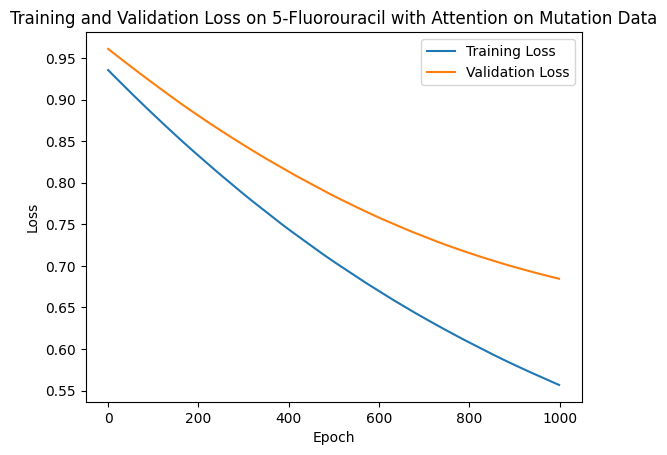

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss on 5-Fluorouracil with Attention on Mutation Data')
ax.legend()

In [ ]:
predictions=model.predict([flu_test_mut, flu_test_cnv, flu_test_meth, flu_test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(flu_y["measure_of_response"], binary_predictions)

precision = precision_score(flu_y["measure_of_response"], binary_predictions, zero_division=1)

recall = recall_score(flu_y["measure_of_response"], binary_predictions, zero_division=1)

f1 = f1_score(flu_y["measure_of_response"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(flu_y["measure_of_response"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 6ms/step
Accuracy: 0.3968253968253968
Precision: 0.6428571428571429
Recall: 0.21428571428571427
F1 Score: 0.32142857142857145
Confusion Matrix:
[[16  5]
 [33  9]]


In [ ]:
accuracy = accuracy_score(flu_y["Overall Survival Status"], binary_predictions)

precision = precision_score(flu_y["Overall Survival Status"], binary_predictions, zero_division=1)

recall = recall_score(flu_y["Overall Survival Status"], binary_predictions, zero_division=1)

f1 = f1_score(flu_y["Overall Survival Status"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(flu_y["Overall Survival Status"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5079365079365079
Precision: 0.5
Recall: 0.22580645161290322
F1 Score: 0.3111111111111111
Confusion Matrix:
[[25  7]
 [24  7]]


#### Gemcitabine

In [ ]:
##Input layers
input_mut = Input(shape=(gem_train_mut.shape[1],), name='mut_input')
input_cnv = Input(shape=(gem_train_cnv.shape[1],), name='cnv_input')
input_meth = Input(shape=(gem_train_meth.shape[1],), name='meth_input')
input_mrna = Input(shape=(gem_train_mrna.shape[1],), name='mrna_input')

##Apply attention to the mutation input only
attention_mut = Attention()(tf.expand_dims(input_mut, axis=1))

##Flatten the attention output
flatten_mut = Flatten()(attention_mut)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([flatten_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.000001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 1000
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[gem_train_mut, gem_train_cnv, gem_train_meth, gem_train_mrna],
    y=gem_train_labels,
    epochs=1000,
    batch_size=1,
    validation_data=([gem_val_mut, gem_val_cnv, gem_val_meth, gem_val_mrna], gem_val_labels),
    callbacks=[scheduler]
)

Epoch 1/1000
81/81 [==============================] - 2s 9ms/step - loss: 0.7771 - mae: 0.5126 - val_loss: 0.8299 - val_mae: 0.5386 - lr: 1.0000e-06
Epoch 2/1000
81/81 [==============================] - 0s 5ms/step - loss: 0.7766 - mae: 0.5124 - val_loss: 0.8296 - val_mae: 0.5385 - lr: 1.0000e-06
Epoch 3/1000
81/81 [==============================] - 0s 5ms/step - loss: 0.7762 - mae: 0.5123 - val_loss: 0.8292 - val_mae: 0.5383 - lr: 1.0000e-06
Epoch 4/1000
81/81 [==============================] - 0s 6ms/step - loss: 0.7757 - mae: 0.5121 - val_loss: 0.8288 - val_mae: 0.5382 - lr: 1.0000e-06
Epoch 5/1000
81/81 [==============================] - 0s 6ms/step - loss: 0.7753 - mae: 0.5119 - val_loss: 0.8284 - val_mae: 0.5380 - lr: 1.0000e-06
Epoch 6/1000
81/81 [==============================] - 0s 5ms/step - loss: 0.7748 - mae: 0.5118 - val_loss: 0.8280 - val_mae: 0.5379 - lr: 1.0000e-06
Epoch 7/1000
81/81 [==============================] - 0s 5ms/step - loss: 0.7744 - mae: 0.5117 - val_loss:

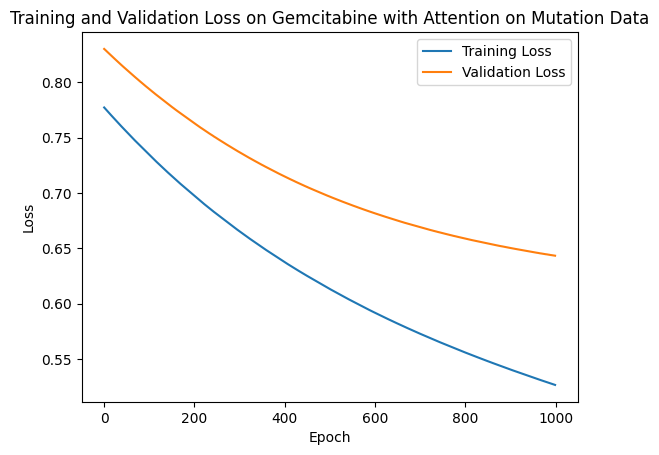

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss on Gemcitabine with Attention on Mutation Data')
ax.legend()

In [ ]:
predictions=model.predict([gem_test_mut, gem_test_cnv, gem_test_meth, gem_test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(gem_y["measure_of_response"], binary_predictions)

precision = precision_score(gem_y["measure_of_response"], binary_predictions, zero_division=1)

recall = recall_score(gem_y["measure_of_response"], binary_predictions, zero_division=1)

f1 = f1_score(gem_y["measure_of_response"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(gem_y["measure_of_response"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 23ms/step
Accuracy: 0.42857142857142855
Precision: 0.26666666666666666
Recall: 0.16
F1 Score: 0.2
Confusion Matrix:
[[20 11]
 [21  4]]


In [ ]:
accuracy = accuracy_score(gem_y["Overall Survival Status"], binary_predictions)

precision = precision_score(gem_y["Overall Survival Status"], binary_predictions, zero_division=1)

recall = recall_score(gem_y["Overall Survival Status"], binary_predictions, zero_division=1)

f1 = f1_score(gem_y["Overall Survival Status"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(gem_y["Overall Survival Status"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5357142857142857
Precision: 0.4
Recall: 0.2608695652173913
F1 Score: 0.31578947368421056
Confusion Matrix:
[[24  9]
 [17  6]]


## On Methylation

In [ ]:
##Input layers
input_mut = Input(shape=(input_mut_shape,), name='mut_input')
input_cnv = Input(shape=(input_cnv_shape,), name='cnv_input')
input_meth = Input(shape=(input_meth_shape,), name='meth_input')
input_mrna = Input(shape=(input_mrna_shape,), name='mrna_input')

##Apply attention to the mutation input only
attention_mut = Attention()(tf.expand_dims(input_mut, axis=1))

##Flatten the attention output
flatten_mut = Flatten()(attention_mut)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([flatten_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.000001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 1000
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Apply attention to the mutation input only
attention_meth = Attention()(tf.expand_dims(input_meth, axis=1))

##Flatten the attention output
flatten_meth = Flatten()(attention_meth)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([input_mut, input_cnv, flatten_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.000001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 1000
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[train_mut, train_cnv, train_meth, train_mrna],
    y=azd_y_train,
    epochs=1200,
    batch_size=1,
    validation_data=([val_mut, val_cnv, val_meth, val_mrna], azd_y_val),
    callbacks=[scheduler]
)

Epoch 1/1200
184/184 [==============================] - 2s 4ms/step - loss: 0.8923 - mae: 0.5471 - val_loss: 0.8632 - val_mae: 0.5409 - lr: 1.0000e-06
Epoch 2/1200
184/184 [==============================] - 1s 3ms/step - loss: 0.8913 - mae: 0.5467 - val_loss: 0.8624 - val_mae: 0.5406 - lr: 1.0000e-06
Epoch 3/1200
184/184 [==============================] - 1s 3ms/step - loss: 0.8903 - mae: 0.5464 - val_loss: 0.8617 - val_mae: 0.5404 - lr: 1.0000e-06
Epoch 4/1200
184/184 [==============================] - 1s 3ms/step - loss: 0.8893 - mae: 0.5461 - val_loss: 0.8609 - val_mae: 0.5401 - lr: 1.0000e-06
Epoch 5/1200
184/184 [==============================] - 1s 4ms/step - loss: 0.8883 - mae: 0.5457 - val_loss: 0.8602 - val_mae: 0.5399 - lr: 1.0000e-06
Epoch 6/1200
184/184 [==============================] - 1s 5ms/step - loss: 0.8874 - mae: 0.5454 - val_loss: 0.8594 - val_mae: 0.5396 - lr: 1.0000e-06
Epoch 7/1200
184/184 [==============================] - 1s 4ms/step - loss: 0.8864 - mae: 0.54

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Attention Layer on Methylation Data')
ax.legend()

In [ ]:
predictions=model.predict([test_mut, test_cnv, test_meth, test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(azd_y_test, binary_predictions)

precision = precision_score(azd_y_test, binary_predictions, zero_division=1)

recall = recall_score(azd_y_test, binary_predictions, zero_division=1)

f1 = f1_score(azd_y_test, binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(azd_y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

### TCGA

#### Cisplatin

In [ ]:
##Input layers
input_mut = Input(shape=(cis_train_mut.shape[1],), name='mut_input')
input_cnv = Input(shape=(cis_train_cnv.shape[1],), name='cnv_input')
input_meth = Input(shape=(cis_train_meth.shape[1],), name='meth_input')
input_mrna = Input(shape=(cis_train_mrna.shape[1],), name='mrna_input')

##Apply attention to the mutation input only
attention_mut = Attention()(tf.expand_dims(input_mut, axis=1))

##Flatten the attention output
flatten_mut = Flatten()(attention_mut)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([flatten_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.000001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 1000
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[cis_train_mut, cis_train_cnv, cis_train_meth, cis_train_mrna],
    y=cis_train_labels,
    epochs=1000,
    batch_size=1,
    validation_data=([cis_val_mut, cis_val_cnv, cis_val_meth, cis_val_mrna], cis_val_labels),
    callbacks=[scheduler]
)

Epoch 1/1000
81/81 [==============================] - 1s 6ms/step - loss: 0.6308 - mae: 0.4499 - val_loss: 0.7393 - val_mae: 0.5001 - lr: 1.0000e-06
Epoch 2/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.6304 - mae: 0.4496 - val_loss: 0.7391 - val_mae: 0.5000 - lr: 1.0000e-06
Epoch 3/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.6300 - mae: 0.4494 - val_loss: 0.7389 - val_mae: 0.4999 - lr: 1.0000e-06
Epoch 4/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.6296 - mae: 0.4492 - val_loss: 0.7387 - val_mae: 0.4997 - lr: 1.0000e-06
Epoch 5/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.6292 - mae: 0.4490 - val_loss: 0.7385 - val_mae: 0.4996 - lr: 1.0000e-06
Epoch 6/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.6289 - mae: 0.4488 - val_loss: 0.7383 - val_mae: 0.4995 - lr: 1.0000e-06
Epoch 7/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.6285 - mae: 0.4486 - val_loss:

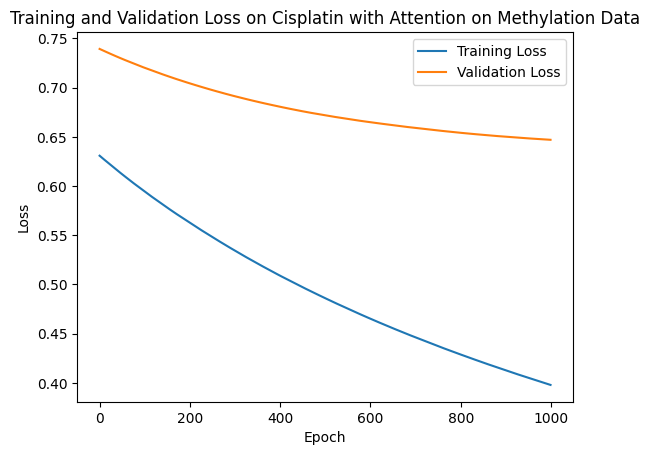

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss on Cisplatin with Attention on Methylation Data')
ax.legend()

In [ ]:
predictions=model.predict([cis_test_mut, cis_test_cnv, cis_test_meth, cis_test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(cis_y["measure_of_response"], binary_predictions)

precision = precision_score(cis_y["measure_of_response"], binary_predictions, zero_division=1)

recall = recall_score(cis_y["measure_of_response"], binary_predictions, zero_division=1)

f1 = f1_score(cis_y["measure_of_response"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(cis_y["measure_of_response"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 6ms/step
Accuracy: 0.5918367346938775
Precision: 0.7222222222222222
Recall: 0.7222222222222222
F1 Score: 0.7222222222222222
Confusion Matrix:
[[ 3 10]
 [10 26]]


In [ ]:
accuracy = accuracy_score(cis_y["Overall Survival Status"], binary_predictions)

precision = precision_score(cis_y["Overall Survival Status"], binary_predictions, zero_division=1)

recall = recall_score(cis_y["Overall Survival Status"], binary_predictions, zero_division=1)

f1 = f1_score(cis_y["Overall Survival Status"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(cis_y["Overall Survival Status"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5306122448979592
Precision: 0.6944444444444444
Recall: 0.6756756756756757
F1 Score: 0.684931506849315
Confusion Matrix:
[[ 1 11]
 [12 25]]


#### 5-Fluorouracil

In [ ]:
##Input layers
input_mut = Input(shape=(flu_train_mut.shape[1],), name='mut_input')
input_cnv = Input(shape=(flu_train_cnv.shape[1],), name='cnv_input')
input_meth = Input(shape=(flu_train_meth.shape[1],), name='meth_input')
input_mrna = Input(shape=(flu_train_mrna.shape[1],), name='mrna_input')

##Apply attention to the mutation input only
attention_mut = Attention()(tf.expand_dims(input_mut, axis=1))

##Flatten the attention output
flatten_mut = Flatten()(attention_mut)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([flatten_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.000001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 1000
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[flu_train_mut, flu_train_cnv, flu_train_meth, flu_train_mrna],
    y=flu_train_labels,
    epochs=1000,
    batch_size=1,
    validation_data=([flu_val_mut, flu_val_cnv, flu_val_meth, flu_val_mrna], flu_val_labels),
    callbacks=[scheduler]
)

Epoch 1/1000
81/81 [==============================] - 2s 6ms/step - loss: 0.7929 - mae: 0.5256 - val_loss: 0.7567 - val_mae: 0.5140 - lr: 1.0000e-06
Epoch 2/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.7925 - mae: 0.5254 - val_loss: 0.7564 - val_mae: 0.5139 - lr: 1.0000e-06
Epoch 3/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.7920 - mae: 0.5252 - val_loss: 0.7561 - val_mae: 0.5138 - lr: 1.0000e-06
Epoch 4/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.7915 - mae: 0.5250 - val_loss: 0.7558 - val_mae: 0.5136 - lr: 1.0000e-06
Epoch 5/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.7910 - mae: 0.5248 - val_loss: 0.7555 - val_mae: 0.5135 - lr: 1.0000e-06
Epoch 6/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.7906 - mae: 0.5247 - val_loss: 0.7552 - val_mae: 0.5134 - lr: 1.0000e-06
Epoch 7/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.7901 - mae: 0.5245 - val_loss:

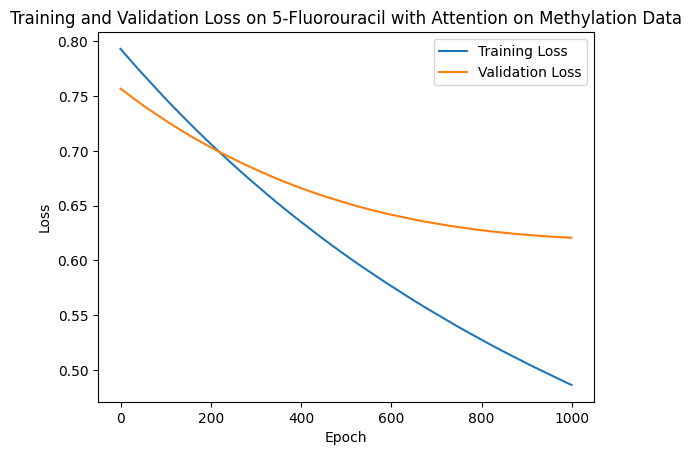

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss on 5-Fluorouracil with Attention on Methylation Data')
ax.legend()

In [ ]:
predictions=model.predict([flu_test_mut, flu_test_cnv, flu_test_meth, flu_test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(flu_y["measure_of_response"], binary_predictions)

precision = precision_score(flu_y["measure_of_response"], binary_predictions, zero_division=1)

recall = recall_score(flu_y["measure_of_response"], binary_predictions, zero_division=1)

f1 = f1_score(flu_y["measure_of_response"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(flu_y["measure_of_response"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 5ms/step
Accuracy: 0.5238095238095238
Precision: 0.6764705882352942
Recall: 0.5476190476190477
F1 Score: 0.605263157894737
Confusion Matrix:
[[10 11]
 [19 23]]


In [ ]:
accuracy = accuracy_score(flu_y["Overall Survival Status"], binary_predictions)

precision = precision_score(flu_y["Overall Survival Status"], binary_predictions, zero_division=1)

recall = recall_score(flu_y["Overall Survival Status"], binary_predictions, zero_division=1)

f1 = f1_score(flu_y["Overall Survival Status"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(flu_y["Overall Survival Status"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.4444444444444444
Precision: 0.4411764705882353
Recall: 0.4838709677419355
F1 Score: 0.4615384615384615
Confusion Matrix:
[[13 19]
 [16 15]]


#### Gemcitabine

In [ ]:
##Input layers
input_mut = Input(shape=(gem_train_mut.shape[1],), name='mut_input')
input_cnv = Input(shape=(gem_train_cnv.shape[1],), name='cnv_input')
input_meth = Input(shape=(gem_train_meth.shape[1],), name='meth_input')
input_mrna = Input(shape=(gem_train_mrna.shape[1],), name='mrna_input')

##Apply attention to the mutation input only
attention_mut = Attention()(tf.expand_dims(input_mut, axis=1))

##Flatten the attention output
flatten_mut = Flatten()(attention_mut)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([flatten_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.000001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 1000
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[gem_train_mut, gem_train_cnv, gem_train_meth, gem_train_mrna],
    y=gem_train_labels,
    epochs=1000,
    batch_size=1,
    validation_data=([gem_val_mut, gem_val_cnv, gem_val_meth, gem_val_mrna], gem_val_labels),
    callbacks=[scheduler]
)

Epoch 1/1000
81/81 [==============================] - 1s 6ms/step - loss: 0.7282 - mae: 0.4831 - val_loss: 0.7857 - val_mae: 0.5160 - lr: 1.0000e-06
Epoch 2/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.7277 - mae: 0.4830 - val_loss: 0.7853 - val_mae: 0.5158 - lr: 1.0000e-06
Epoch 3/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.7273 - mae: 0.4828 - val_loss: 0.7849 - val_mae: 0.5157 - lr: 1.0000e-06
Epoch 4/1000
81/81 [==============================] - 0s 4ms/step - loss: 0.7268 - mae: 0.4827 - val_loss: 0.7846 - val_mae: 0.5156 - lr: 1.0000e-06
Epoch 5/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.7264 - mae: 0.4825 - val_loss: 0.7843 - val_mae: 0.5155 - lr: 1.0000e-06
Epoch 6/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.7260 - mae: 0.4823 - val_loss: 0.7839 - val_mae: 0.5154 - lr: 1.0000e-06
Epoch 7/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.7255 - mae: 0.4822 - val_loss:

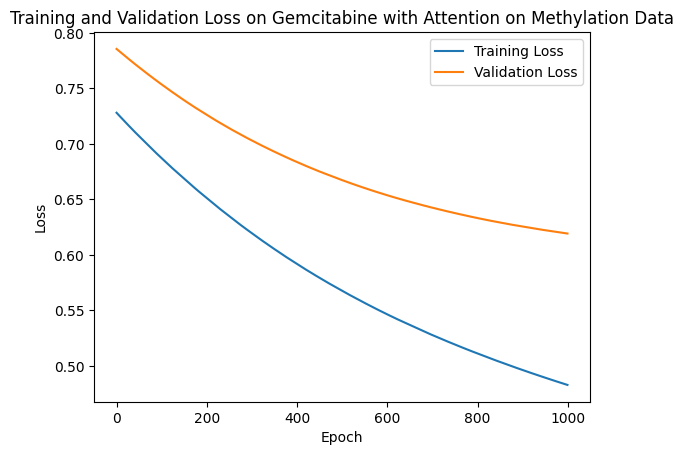

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss on Gemcitabine with Attention on Methylation Data')
ax.legend()

In [ ]:
predictions=model.predict([gem_test_mut, gem_test_cnv, gem_test_meth, gem_test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(gem_y["measure_of_response"], binary_predictions)

precision = precision_score(gem_y["measure_of_response"], binary_predictions, zero_division=1)

recall = recall_score(gem_y["measure_of_response"], binary_predictions, zero_division=1)

f1 = f1_score(gem_y["measure_of_response"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(gem_y["measure_of_response"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 6ms/step
Accuracy: 0.5357142857142857
Precision: 0.47368421052631576
Recall: 0.36
F1 Score: 0.40909090909090906
Confusion Matrix:
[[21 10]
 [16  9]]


In [ ]:
accuracy = accuracy_score(gem_y["Overall Survival Status"], binary_predictions)

precision = precision_score(gem_y["Overall Survival Status"], binary_predictions, zero_division=1)

recall = recall_score(gem_y["Overall Survival Status"], binary_predictions, zero_division=1)

f1 = f1_score(gem_y["Overall Survival Status"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(gem_y["Overall Survival Status"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.6428571428571429
Precision: 0.5789473684210527
Recall: 0.4782608695652174
F1 Score: 0.5238095238095238
Confusion Matrix:
[[25  8]
 [12 11]]


## On Copy Number Variation

In [ ]:
##Redefine input layers
input_mut = Input(shape=(input_mut_shape,), name='mut_input')
input_cnv = Input(shape=(input_cnv_shape,), name='cnv_input')
input_meth = Input(shape=(input_meth_shape,), name='meth_input')
input_mrna = Input(shape=(input_mrna_shape,), name='mrna_input')

In [ ]:
##Apply attention to the mutation input only
attention_cnv = Attention()(tf.expand_dims(input_cnv, axis=1))

##Flatten the attention output
flatten_cnv = Flatten()(attention_cnv)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([flatten_cnv, input_meth, input_mut, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.000001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 1000
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[train_mut, train_cnv, train_meth, train_mrna],
    y=azd_y_train,
    epochs=1000,
    batch_size=1,
    validation_data=([val_mut, val_cnv, val_meth, val_mrna], azd_y_val),
    callbacks=[scheduler]
)

Epoch 1/1000
184/184 [==============================] - 3s 7ms/step - loss: 0.6552 - mae: 0.4431 - val_loss: 0.7145 - val_mae: 0.4646 - lr: 1.0000e-06
Epoch 2/1000
184/184 [==============================] - 1s 3ms/step - loss: 0.6546 - mae: 0.4428 - val_loss: 0.7140 - val_mae: 0.4644 - lr: 1.0000e-06
Epoch 3/1000
184/184 [==============================] - 1s 3ms/step - loss: 0.6540 - mae: 0.4425 - val_loss: 0.7136 - val_mae: 0.4642 - lr: 1.0000e-06
Epoch 4/1000
184/184 [==============================] - 0s 3ms/step - loss: 0.6535 - mae: 0.4423 - val_loss: 0.7131 - val_mae: 0.4640 - lr: 1.0000e-06
Epoch 5/1000
184/184 [==============================] - 0s 3ms/step - loss: 0.6529 - mae: 0.4420 - val_loss: 0.7127 - val_mae: 0.4638 - lr: 1.0000e-06
Epoch 6/1000
184/184 [==============================] - 1s 3ms/step - loss: 0.6524 - mae: 0.4417 - val_loss: 0.7122 - val_mae: 0.4636 - lr: 1.0000e-06
Epoch 7/1000
184/184 [==============================] - 0s 3ms/step - loss: 0.6518 - mae: 0.44

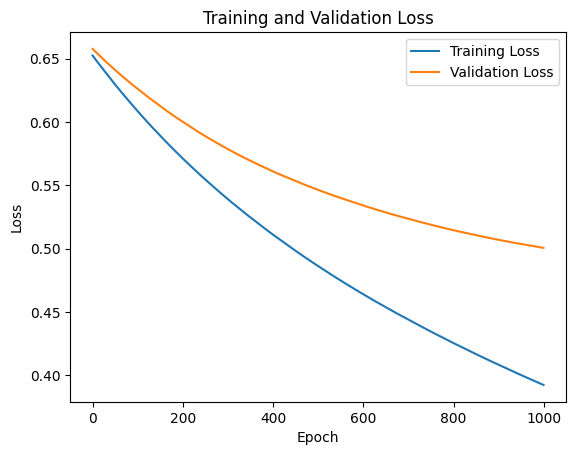

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Attention Layer on Copy Number Variation')
ax.legend()

In [ ]:
predictions=model.predict([test_mut, test_cnv, test_meth, test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(azd_y_test, binary_predictions)

precision = precision_score(azd_y_test, binary_predictions, zero_division=1)

recall = recall_score(azd_y_test, binary_predictions, zero_division=1)

f1 = f1_score(azd_y_test, binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(azd_y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 5ms/step
Accuracy: 0.78125
Precision: 1.0
Recall: 0.3
F1 Score: 0.4615384615384615
Confusion Matrix:
[[44  0]
 [14  6]]


### TCGA

#### Cisplatin

In [ ]:
##Input layers
input_mut = Input(shape=(cis_train_mut.shape[1],), name='mut_input')
input_cnv = Input(shape=(cis_train_cnv.shape[1],), name='cnv_input')
input_meth = Input(shape=(cis_train_meth.shape[1],), name='meth_input')
input_mrna = Input(shape=(cis_train_mrna.shape[1],), name='mrna_input')

##Apply attention to the mutation input only
attention_mut = Attention()(tf.expand_dims(input_mut, axis=1))

##Flatten the attention output
flatten_mut = Flatten()(attention_mut)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([flatten_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.000001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 1000
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[cis_train_mut, cis_train_cnv, cis_train_meth, cis_train_mrna],
    y=cis_train_labels,
    epochs=1000,
    batch_size=1,
    validation_data=([cis_val_mut, cis_val_cnv, cis_val_meth, cis_val_mrna], cis_val_labels),
    callbacks=[scheduler]
)

Epoch 1/1000
81/81 [==============================] - 2s 10ms/step - loss: 0.6270 - mae: 0.4028 - val_loss: 0.7120 - val_mae: 0.4576 - lr: 1.0000e-06
Epoch 2/1000
81/81 [==============================] - 0s 5ms/step - loss: 0.6266 - mae: 0.4027 - val_loss: 0.7118 - val_mae: 0.4575 - lr: 1.0000e-06
Epoch 3/1000
81/81 [==============================] - 1s 7ms/step - loss: 0.6262 - mae: 0.4025 - val_loss: 0.7117 - val_mae: 0.4574 - lr: 1.0000e-06
Epoch 4/1000
81/81 [==============================] - 0s 5ms/step - loss: 0.6259 - mae: 0.4024 - val_loss: 0.7115 - val_mae: 0.4573 - lr: 1.0000e-06
Epoch 5/1000
81/81 [==============================] - 0s 5ms/step - loss: 0.6255 - mae: 0.4022 - val_loss: 0.7113 - val_mae: 0.4572 - lr: 1.0000e-06
Epoch 6/1000
81/81 [==============================] - 0s 6ms/step - loss: 0.6251 - mae: 0.4020 - val_loss: 0.7111 - val_mae: 0.4571 - lr: 1.0000e-06
Epoch 7/1000
81/81 [==============================] - 0s 3ms/step - loss: 0.6247 - mae: 0.4019 - val_loss

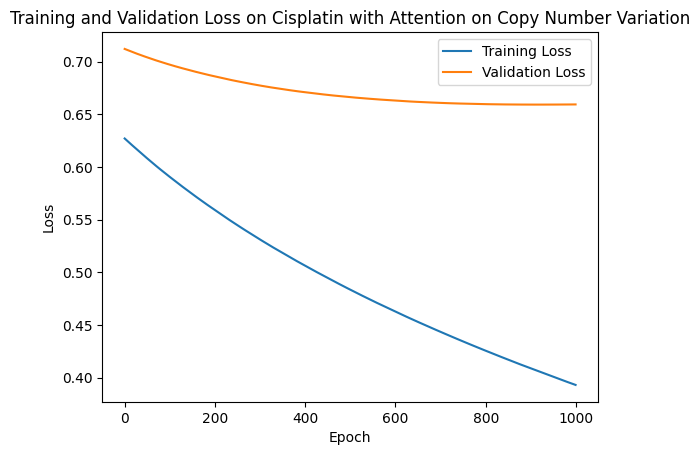

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss on Cisplatin with Attention on Copy Number Variation')
ax.legend()

In [ ]:
predictions=model.predict([cis_test_mut, cis_test_cnv, cis_test_meth, cis_test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(cis_y["measure_of_response"], binary_predictions)

precision = precision_score(cis_y["measure_of_response"], binary_predictions, zero_division=1)

recall = recall_score(cis_y["measure_of_response"], binary_predictions, zero_division=1)

f1 = f1_score(cis_y["measure_of_response"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(cis_y["measure_of_response"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 5ms/step
Accuracy: 0.6938775510204082
Precision: 0.7333333333333333
Recall: 0.9166666666666666
F1 Score: 0.8148148148148148
Confusion Matrix:
[[ 1 12]
 [ 3 33]]


In [ ]:
accuracy = accuracy_score(cis_y["Overall Survival Status"], binary_predictions)

precision = precision_score(cis_y["Overall Survival Status"], binary_predictions, zero_division=1)

recall = recall_score(cis_y["Overall Survival Status"], binary_predictions, zero_division=1)

f1 = f1_score(cis_y["Overall Survival Status"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(cis_y["Overall Survival Status"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.673469387755102
Precision: 0.7333333333333333
Recall: 0.8918918918918919
F1 Score: 0.8048780487804879
Confusion Matrix:
[[ 0 12]
 [ 4 33]]


#### 5-Fluorouracil

In [ ]:
##Input layers
input_mut = Input(shape=(flu_train_mut.shape[1],), name='mut_input')
input_cnv = Input(shape=(flu_train_cnv.shape[1],), name='cnv_input')
input_meth = Input(shape=(flu_train_meth.shape[1],), name='meth_input')
input_mrna = Input(shape=(flu_train_mrna.shape[1],), name='mrna_input')

##Apply attention to the mutation input only
attention_mut = Attention()(tf.expand_dims(input_mut, axis=1))

##Flatten the attention output
flatten_mut = Flatten()(attention_mut)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([flatten_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.000001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 100
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[flu_train_mut, flu_train_cnv, flu_train_meth, flu_train_mrna],
    y=flu_train_labels,
    epochs=1000,
    batch_size=1,
    validation_data=([flu_val_mut, flu_val_cnv, flu_val_meth, flu_val_mrna], flu_val_labels),
    callbacks=[scheduler]
)

Epoch 1/1000
81/81 [==============================] - 3s 14ms/step - loss: 0.8267 - mae: 0.5132 - val_loss: 0.7372 - val_mae: 0.4672 - lr: 1.0000e-06
Epoch 2/1000
81/81 [==============================] - 1s 8ms/step - loss: 0.8263 - mae: 0.5130 - val_loss: 0.7369 - val_mae: 0.4671 - lr: 1.0000e-06
Epoch 3/1000
81/81 [==============================] - 1s 7ms/step - loss: 0.8259 - mae: 0.5129 - val_loss: 0.7367 - val_mae: 0.4670 - lr: 1.0000e-06
Epoch 4/1000
81/81 [==============================] - 1s 9ms/step - loss: 0.8254 - mae: 0.5128 - val_loss: 0.7364 - val_mae: 0.4669 - lr: 1.0000e-06
Epoch 5/1000
81/81 [==============================] - 1s 6ms/step - loss: 0.8250 - mae: 0.5126 - val_loss: 0.7362 - val_mae: 0.4668 - lr: 1.0000e-06
Epoch 6/1000
81/81 [==============================] - 1s 6ms/step - loss: 0.8245 - mae: 0.5125 - val_loss: 0.7359 - val_mae: 0.4667 - lr: 1.0000e-06
Epoch 7/1000
81/81 [==============================] - 0s 5ms/step - loss: 0.8241 - mae: 0.5123 - val_loss

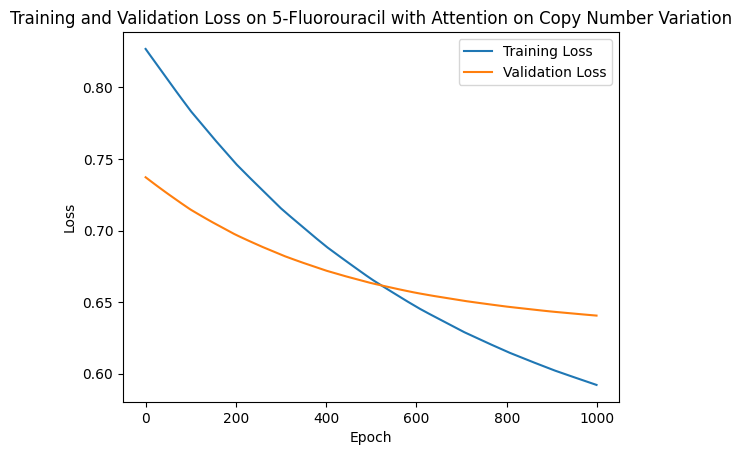

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss on 5-Fluorouracil with Attention on Copy Number Variation')
ax.legend()

In [ ]:
predictions=model.predict([flu_test_mut, flu_test_cnv, flu_test_meth, flu_test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(flu_y["measure_of_response"], binary_predictions)

precision = precision_score(flu_y["measure_of_response"], binary_predictions, zero_division=1)

recall = recall_score(flu_y["measure_of_response"], binary_predictions, zero_division=1)

f1 = f1_score(flu_y["measure_of_response"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(flu_y["measure_of_response"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 10ms/step
Accuracy: 0.3968253968253968
Precision: 0.5833333333333334
Recall: 0.3333333333333333
F1 Score: 0.4242424242424242
Confusion Matrix:
[[11 10]
 [28 14]]


In [ ]:
accuracy = accuracy_score(flu_y["Overall Survival Status"], binary_predictions)

precision = precision_score(flu_y["Overall Survival Status"], binary_predictions, zero_division=1)

recall = recall_score(flu_y["Overall Survival Status"], binary_predictions, zero_division=1)

f1 = f1_score(flu_y["Overall Survival Status"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(flu_y["Overall Survival Status"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5079365079365079
Precision: 0.5
Recall: 0.3870967741935484
F1 Score: 0.43636363636363634
Confusion Matrix:
[[20 12]
 [19 12]]


#### Gemcitabine

In [ ]:
##Input layers
input_mut = Input(shape=(gem_train_mut.shape[1],), name='mut_input')
input_cnv = Input(shape=(gem_train_cnv.shape[1],), name='cnv_input')
input_meth = Input(shape=(gem_train_meth.shape[1],), name='meth_input')
input_mrna = Input(shape=(gem_train_mrna.shape[1],), name='mrna_input')

##Apply attention to the mutation input only
attention_mut = Attention()(tf.expand_dims(input_mut, axis=1))

##Flatten the attention output
flatten_mut = Flatten()(attention_mut)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([flatten_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.00001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 50
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[gem_train_mut, gem_train_cnv, gem_train_meth, gem_train_mrna],
    y=gem_train_labels,
    epochs=300,
    batch_size=1,
    validation_data=([gem_val_mut, gem_val_cnv, gem_val_meth, gem_val_mrna], gem_val_labels),
    callbacks=[scheduler]
)

Epoch 1/300
81/81 [==============================] - 4s 27ms/step - loss: 0.9652 - mae: 0.5409 - val_loss: 1.0494 - val_mae: 0.5832 - lr: 1.0000e-05
Epoch 2/300
81/81 [==============================] - 1s 7ms/step - loss: 0.9579 - mae: 0.5394 - val_loss: 1.0426 - val_mae: 0.5817 - lr: 1.0000e-05
Epoch 3/300
81/81 [==============================] - 1s 12ms/step - loss: 0.9509 - mae: 0.5380 - val_loss: 1.0358 - val_mae: 0.5801 - lr: 1.0000e-05
Epoch 4/300
81/81 [==============================] - 1s 10ms/step - loss: 0.9437 - mae: 0.5367 - val_loss: 1.0289 - val_mae: 0.5784 - lr: 1.0000e-05
Epoch 5/300
81/81 [==============================] - 1s 9ms/step - loss: 0.9367 - mae: 0.5352 - val_loss: 1.0220 - val_mae: 0.5768 - lr: 1.0000e-05
Epoch 6/300
81/81 [==============================] - 1s 10ms/step - loss: 0.9300 - mae: 0.5338 - val_loss: 1.0152 - val_mae: 0.5751 - lr: 1.0000e-05
Epoch 7/300
81/81 [==============================] - 1s 9ms/step - loss: 0.9232 - mae: 0.5324 - val_loss: 1.

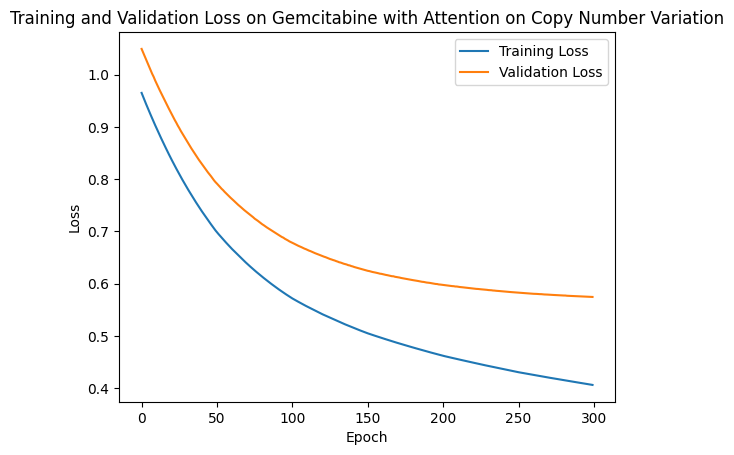

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss on Gemcitabine with Attention on Copy Number Variation')
ax.legend()

In [ ]:
predictions=model.predict([gem_test_mut, gem_test_cnv, gem_test_meth, gem_test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(gem_y["measure_of_response"], binary_predictions)

precision = precision_score(gem_y["measure_of_response"], binary_predictions, zero_division=1)

recall = recall_score(gem_y["measure_of_response"], binary_predictions, zero_division=1)

f1 = f1_score(gem_y["measure_of_response"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(gem_y["measure_of_response"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 10ms/step
Accuracy: 0.5357142857142857
Precision: 0.47058823529411764
Recall: 0.32
F1 Score: 0.38095238095238104
Confusion Matrix:
[[22  9]
 [17  8]]


In [ ]:
accuracy = accuracy_score(gem_y["Overall Survival Status"], binary_predictions)

precision = precision_score(gem_y["Overall Survival Status"], binary_predictions, zero_division=1)

recall = recall_score(gem_y["Overall Survival Status"], binary_predictions, zero_division=1)

f1 = f1_score(gem_y["Overall Survival Status"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(gem_y["Overall Survival Status"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.6428571428571429
Precision: 0.5882352941176471
Recall: 0.43478260869565216
F1 Score: 0.5
Confusion Matrix:
[[26  7]
 [13 10]]


## On mRNA

In [ ]:
## Redefine input layers
input_mut = Input(shape=(input_mut_shape,), name='mut_input')
input_cnv = Input(shape=(input_cnv_shape,), name='cnv_input')
input_meth = Input(shape=(input_meth_shape,), name='meth_input')
input_mrna = Input(shape=(input_mrna_shape,), name='mrna_input')

In [ ]:
##Apply attention to the mutation input only
attention_mrna = Attention()(tf.expand_dims(input_mrna, axis=1))

##Flatten the attention output
flatten_mrna = Flatten()(attention_mrna)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([flatten_mrna, input_cnv, input_mut, input_meth])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.00001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[train_mut, train_cnv, train_meth, train_mrna],
    y=azd_y_train,
    epochs=400,
    batch_size=1,
    validation_data=([val_mut, val_cnv, val_meth, val_mrna], azd_y_val),
    callbacks=[scheduler]
)

Epoch 1/400
184/184 [==============================] - 2s 4ms/step - loss: 0.7516 - mae: 0.5021 - val_loss: 0.7108 - val_mae: 0.4780 - lr: 1.0000e-05
Epoch 2/400
184/184 [==============================] - 0s 3ms/step - loss: 0.7439 - mae: 0.4987 - val_loss: 0.7067 - val_mae: 0.4759 - lr: 1.0000e-05
Epoch 3/400
184/184 [==============================] - 0s 3ms/step - loss: 0.7365 - mae: 0.4953 - val_loss: 0.7026 - val_mae: 0.4737 - lr: 1.0000e-05
Epoch 4/400
184/184 [==============================] - 1s 3ms/step - loss: 0.7293 - mae: 0.4918 - val_loss: 0.6983 - val_mae: 0.4714 - lr: 1.0000e-05
Epoch 5/400
184/184 [==============================] - 1s 3ms/step - loss: 0.7221 - mae: 0.4884 - val_loss: 0.6946 - val_mae: 0.4694 - lr: 1.0000e-05
Epoch 6/400
184/184 [==============================] - 1s 5ms/step - loss: 0.7152 - mae: 0.4850 - val_loss: 0.6908 - val_mae: 0.4674 - lr: 1.0000e-05
Epoch 7/400
184/184 [==============================] - 1s 5ms/step - loss: 0.7084 - mae: 0.4818 - va

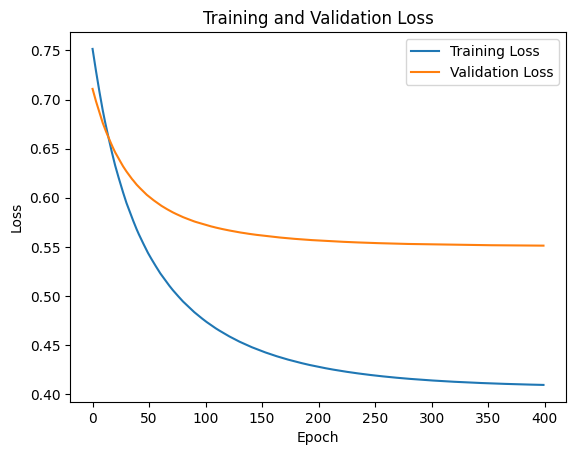

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss')
ax.legend()

In [ ]:
predictions=model.predict([test_mut, test_cnv, test_meth, test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(azd_y_test, binary_predictions)

precision = precision_score(azd_y_test, binary_predictions, zero_division=1)

recall = recall_score(azd_y_test, binary_predictions, zero_division=1)

f1 = f1_score(azd_y_test, binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(azd_y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 5ms/step
Accuracy: 0.734375
Precision: 0.8
Recall: 0.2
F1 Score: 0.32000000000000006
Confusion Matrix:
[[43  1]
 [16  4]]


In [ ]:
##Add an attention layer to the mutation input
attention_mut = Attention()(tf.expand_dims(input_mut, axis=1))
attention_cnv = Attention()(tf.expand_dims(input_cnv, axis=1))
attention_meth = Attention()(tf.expand_dims(input_meth, axis=1))
attention_mrna = Attention()(tf.expand_dims(input_mrna, axis=1))

##Flatten the input data
flatten_mut = Flatten()(attention_mut)
flatten_cnv = Flatten()(input_cnv)
flatten_meth = Flatten()(input_meth)
flatten_mrna = Flatten()(input_mrna)

##Concatenate all inputs
concatenated = Concatenate()([flatten_mut, flatten_cnv, flatten_meth, flatten_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

In [ ]:
history = model.fit(
    x=[train_mut, train_cnv, train_meth, train_mrna],
    y=azd_y_train,
    epochs=1000,
    batch_size=32,
    validation_data=([val_mut, val_cnv, val_meth, val_mrna], azd_y_val),
    callbacks=[scheduler]
)

Epoch 1/1000
6/6 [==============================] - 0s 30ms/step - loss: 0.6121 - mae: 0.4330 - val_loss: 0.6703 - val_mae: 0.4688 - lr: 1.0000e-05
Epoch 2/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.6115 - mae: 0.4326 - val_loss: 0.6699 - val_mae: 0.4686 - lr: 1.0000e-05
Epoch 3/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.6109 - mae: 0.4323 - val_loss: 0.6694 - val_mae: 0.4683 - lr: 1.0000e-05
Epoch 4/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.6103 - mae: 0.4320 - val_loss: 0.6690 - val_mae: 0.4681 - lr: 1.0000e-05
Epoch 5/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.6096 - mae: 0.4317 - val_loss: 0.6685 - val_mae: 0.4679 - lr: 1.0000e-05
Epoch 6/1000
6/6 [==============================] - 0s 22ms/step - loss: 0.6090 - mae: 0.4313 - val_loss: 0.6680 - val_mae: 0.4676 - lr: 1.0000e-05
Epoch 7/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.6084 - mae: 0.4310 - val_loss: 0.6676

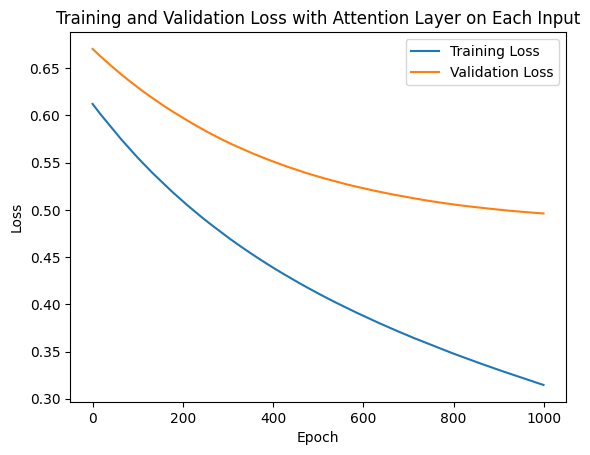

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss with Attention Layer on Each Input')
ax.legend()

In [ ]:
predictions=model.predict([test_mut, test_cnv, test_meth, test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(azd_y_test, binary_predictions)

precision = precision_score(azd_y_test, binary_predictions, zero_division=1)

recall = recall_score(azd_y_test, binary_predictions, zero_division=1)

f1 = f1_score(azd_y_test, binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(azd_y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 8ms/step
Accuracy: 0.703125
Precision: 0.6
Recall: 0.15
F1 Score: 0.24
Confusion Matrix:
[[42  2]
 [17  3]]


### TCGA

#### Cisplatin

In [ ]:
##Input layers
input_mut = Input(shape=(cis_train_mut.shape[1],), name='mut_input')
input_cnv = Input(shape=(cis_train_cnv.shape[1],), name='cnv_input')
input_meth = Input(shape=(cis_train_meth.shape[1],), name='meth_input')
input_mrna = Input(shape=(cis_train_mrna.shape[1],), name='mrna_input')

##Apply attention to the mutation input only
attention_mut = Attention()(tf.expand_dims(input_mut, axis=1))

##Flatten the attention output
flatten_mut = Flatten()(attention_mut)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([flatten_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)
##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.00001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 100
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[cis_train_mut, cis_train_cnv, cis_train_meth, cis_train_mrna],
    y=cis_train_labels,
    epochs=300,
    batch_size=1,
    validation_data=([cis_val_mut, cis_val_cnv, cis_val_meth, cis_val_mrna], cis_val_labels),
    callbacks=[scheduler]
)

Epoch 1/300
81/81 [==============================] - 4s 20ms/step - loss: 0.8203 - mae: 0.5176 - val_loss: 0.9774 - val_mae: 0.5654 - lr: 1.0000e-05
Epoch 2/300
81/81 [==============================] - 0s 6ms/step - loss: 0.8138 - mae: 0.5152 - val_loss: 0.9728 - val_mae: 0.5642 - lr: 1.0000e-05
Epoch 3/300
81/81 [==============================] - 0s 5ms/step - loss: 0.8074 - mae: 0.5127 - val_loss: 0.9678 - val_mae: 0.5630 - lr: 1.0000e-05
Epoch 4/300
81/81 [==============================] - 0s 6ms/step - loss: 0.8010 - mae: 0.5103 - val_loss: 0.9634 - val_mae: 0.5618 - lr: 1.0000e-05
Epoch 5/300
81/81 [==============================] - 1s 8ms/step - loss: 0.7950 - mae: 0.5079 - val_loss: 0.9586 - val_mae: 0.5606 - lr: 1.0000e-05
Epoch 6/300
81/81 [==============================] - 0s 6ms/step - loss: 0.7887 - mae: 0.5057 - val_loss: 0.9541 - val_mae: 0.5593 - lr: 1.0000e-05
Epoch 7/300
81/81 [==============================] - 0s 5ms/step - loss: 0.7826 - mae: 0.5033 - val_loss: 0.949

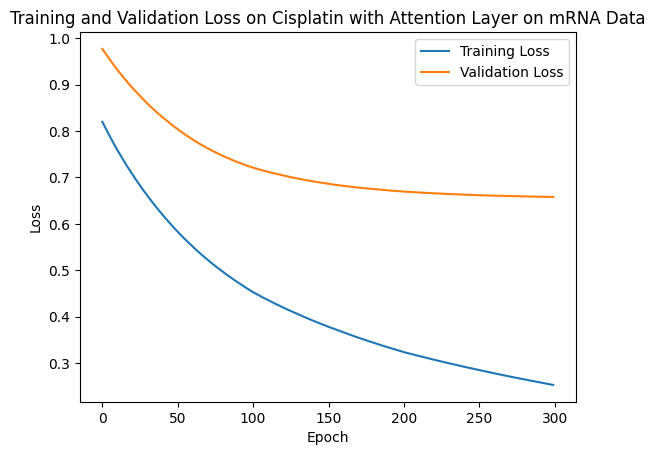

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss on Cisplatin with Attention Layer on mRNA Data')
ax.legend()

In [ ]:
predictions=model.predict([cis_test_mut, cis_test_cnv, cis_test_meth, cis_test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(cis_y["measure_of_response"], binary_predictions)

precision = precision_score(cis_y["measure_of_response"], binary_predictions, zero_division=1)

recall = recall_score(cis_y["measure_of_response"], binary_predictions, zero_division=1)

f1 = f1_score(cis_y["measure_of_response"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(cis_y["measure_of_response"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 6ms/step
Accuracy: 0.5306122448979592
Precision: 0.9333333333333333
Recall: 0.3888888888888889
F1 Score: 0.5490196078431373
Confusion Matrix:
[[12  1]
 [22 14]]


In [ ]:
accuracy = accuracy_score(cis_y["Overall Survival Status"], binary_predictions)

precision = precision_score(cis_y["Overall Survival Status"], binary_predictions, zero_division=1)

recall = recall_score(cis_y["Overall Survival Status"], binary_predictions, zero_division=1)

f1 = f1_score(cis_y["Overall Survival Status"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(cis_y["Overall Survival Status"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.42857142857142855
Precision: 0.8
Recall: 0.32432432432432434
F1 Score: 0.46153846153846156
Confusion Matrix:
[[ 9  3]
 [25 12]]


#### 5-Fluorouracil

In [ ]:
##Input layers
input_mut = Input(shape=(flu_train_mut.shape[1],), name='mut_input')
input_cnv = Input(shape=(flu_train_cnv.shape[1],), name='cnv_input')
input_meth = Input(shape=(flu_train_meth.shape[1],), name='meth_input')
input_mrna = Input(shape=(flu_train_mrna.shape[1],), name='mrna_input')

##Apply attention to the mutation input only
attention_mut = Attention()(tf.expand_dims(input_mut, axis=1))

##Flatten the attention output
flatten_mut = Flatten()(attention_mut)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([flatten_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.000001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 100
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[flu_train_mut, flu_train_cnv, flu_train_meth, flu_train_mrna],
    y=flu_train_labels,
    epochs=500,
    batch_size=1,
    validation_data=([flu_val_mut, flu_val_cnv, flu_val_meth, flu_val_mrna], flu_val_labels),
    callbacks=[scheduler]
)

Epoch 1/500
81/81 [==============================] - 1s 7ms/step - loss: 0.6338 - mae: 0.4333 - val_loss: 0.6754 - val_mae: 0.4581 - lr: 8.1000e-07
Epoch 2/500
81/81 [==============================] - 0s 6ms/step - loss: 0.6336 - mae: 0.4332 - val_loss: 0.6752 - val_mae: 0.4580 - lr: 8.1000e-07
Epoch 3/500
81/81 [==============================] - 0s 5ms/step - loss: 0.6333 - mae: 0.4331 - val_loss: 0.6751 - val_mae: 0.4580 - lr: 8.1000e-07
Epoch 4/500
81/81 [==============================] - 0s 6ms/step - loss: 0.6331 - mae: 0.4330 - val_loss: 0.6750 - val_mae: 0.4579 - lr: 8.1000e-07
Epoch 5/500
81/81 [==============================] - 0s 6ms/step - loss: 0.6328 - mae: 0.4328 - val_loss: 0.6749 - val_mae: 0.4579 - lr: 8.1000e-07
Epoch 6/500
81/81 [==============================] - 1s 7ms/step - loss: 0.6326 - mae: 0.4327 - val_loss: 0.6748 - val_mae: 0.4578 - lr: 8.1000e-07
Epoch 7/500
81/81 [==============================] - 1s 7ms/step - loss: 0.6323 - mae: 0.4326 - val_loss: 0.6746

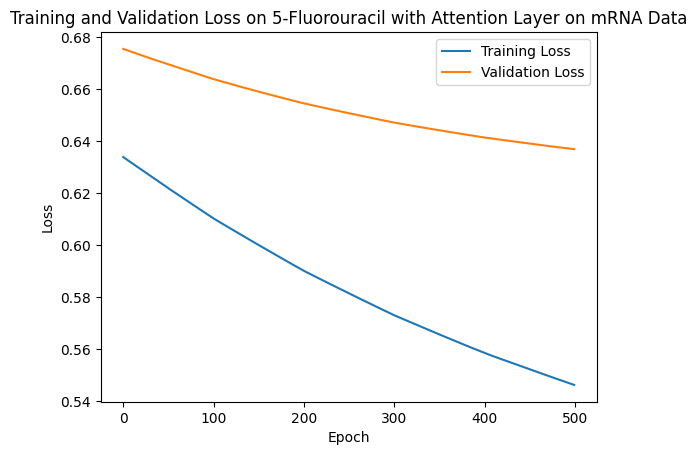

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss on 5-Fluorouracil with Attention Layer on mRNA Data')
ax.legend()

In [ ]:
predictions=model.predict([flu_test_mut, flu_test_cnv, flu_test_meth, flu_test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(flu_y["measure_of_response"], binary_predictions)

precision = precision_score(flu_y["measure_of_response"], binary_predictions, zero_division=1)

recall = recall_score(flu_y["measure_of_response"], binary_predictions, zero_division=1)

f1 = f1_score(flu_y["measure_of_response"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(flu_y["measure_of_response"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 6ms/step
Accuracy: 0.4603174603174603
Precision: 0.6428571428571429
Recall: 0.42857142857142855
F1 Score: 0.5142857142857143
Confusion Matrix:
[[11 10]
 [24 18]]


In [ ]:
accuracy = accuracy_score(flu_y["Overall Survival Status"], binary_predictions)

precision = precision_score(flu_y["Overall Survival Status"], binary_predictions, zero_division=1)

recall = recall_score(flu_y["Overall Survival Status"], binary_predictions, zero_division=1)

f1 = f1_score(flu_y["Overall Survival Status"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(flu_y["Overall Survival Status"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.47619047619047616
Precision: 0.4642857142857143
Recall: 0.41935483870967744
F1 Score: 0.44067796610169496
Confusion Matrix:
[[17 15]
 [18 13]]


#### Gemcitabine

In [ ]:
##Input layers
input_mut = Input(shape=(gem_train_mut.shape[1],), name='mut_input')
input_cnv = Input(shape=(gem_train_cnv.shape[1],), name='cnv_input')
input_meth = Input(shape=(gem_train_meth.shape[1],), name='meth_input')
input_mrna = Input(shape=(gem_train_mrna.shape[1],), name='mrna_input')

##Apply attention to the mutation input only
attention_mut = Attention()(tf.expand_dims(input_mut, axis=1))

##Flatten the attention output
flatten_mut = Flatten()(attention_mut)

##Concatenate all the inputs (including the attention-applied mutation input)
concatenated = Concatenate()([flatten_mut, input_cnv, input_meth, input_mrna])

##Add dense layers
dense_1 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

##Define the model
model = Model(inputs=[input_mut, input_cnv, input_meth, input_mrna], outputs=output)

##Compile the model
lr = 0.000001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

##Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 1000
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

##Create a LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_scheduler)

In [ ]:
##Train the model
history = model.fit(
    x=[gem_train_mut, gem_train_cnv, gem_train_meth, gem_train_mrna],
    y=gem_train_labels,
    epochs=600,
    batch_size=1,
    validation_data=([gem_val_mut, gem_val_cnv, gem_val_meth, gem_val_mrna], gem_val_labels),
    callbacks=[scheduler]
)

Epoch 1/600
81/81 [==============================] - 1s 9ms/step - loss: 0.8165 - mae: 0.5109 - val_loss: 0.7075 - val_mae: 0.4738 - lr: 1.0000e-06
Epoch 2/600
81/81 [==============================] - 1s 6ms/step - loss: 0.8161 - mae: 0.5107 - val_loss: 0.7073 - val_mae: 0.4737 - lr: 1.0000e-06
Epoch 3/600
81/81 [==============================] - 1s 6ms/step - loss: 0.8158 - mae: 0.5106 - val_loss: 0.7071 - val_mae: 0.4736 - lr: 1.0000e-06
Epoch 4/600
81/81 [==============================] - 1s 7ms/step - loss: 0.8154 - mae: 0.5105 - val_loss: 0.7069 - val_mae: 0.4736 - lr: 1.0000e-06
Epoch 5/600
81/81 [==============================] - 1s 10ms/step - loss: 0.8150 - mae: 0.5104 - val_loss: 0.7067 - val_mae: 0.4735 - lr: 1.0000e-06
Epoch 6/600
81/81 [==============================] - 1s 8ms/step - loss: 0.8147 - mae: 0.5103 - val_loss: 0.7065 - val_mae: 0.4734 - lr: 1.0000e-06
Epoch 7/600
81/81 [==============================] - 1s 10ms/step - loss: 0.8143 - mae: 0.5101 - val_loss: 0.70

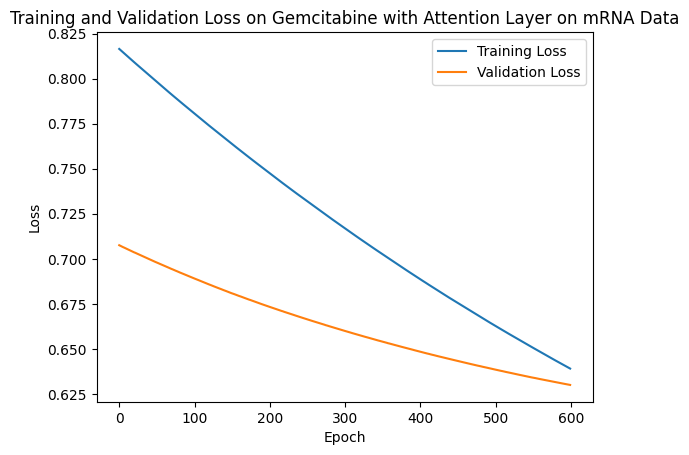

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss on Gemcitabine with Attention Layer on mRNA Data')
ax.legend()

In [ ]:
predictions=model.predict([gem_test_mut, gem_test_cnv, gem_test_meth, gem_test_mrna])
binary_predictions = (predictions > threshold).astype(int)
accuracy = accuracy_score(gem_y["measure_of_response"], binary_predictions)

precision = precision_score(gem_y["measure_of_response"], binary_predictions, zero_division=1)

recall = recall_score(gem_y["measure_of_response"], binary_predictions, zero_division=1)

f1 = f1_score(gem_y["measure_of_response"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(gem_y["measure_of_response"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 6ms/step
Accuracy: 0.375
Precision: 0.3076923076923077
Recall: 0.32
F1 Score: 0.3137254901960784
Confusion Matrix:
[[13 18]
 [17  8]]


In [ ]:
accuracy = accuracy_score(gem_y["Overall Survival Status"], binary_predictions)

precision = precision_score(gem_y["Overall Survival Status"], binary_predictions, zero_division=1)

recall = recall_score(gem_y["Overall Survival Status"], binary_predictions, zero_division=1)

f1 = f1_score(gem_y["Overall Survival Status"], binary_predictions, zero_division=1)

conf_matrix = confusion_matrix(gem_y["Overall Survival Status"], binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5535714285714286
Precision: 0.46153846153846156
Recall: 0.5217391304347826
F1 Score: 0.4897959183673469
Confusion Matrix:
[[19 14]
 [11 12]]
